# **1. Data Pre Proccessing**

In [ ]:
# Google drive and google collab connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# In google collab pyspark is not pre installed
!pip install pyspark

### **Preparing Data**

In [ ]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Pysaprk Library
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, median, stddev

In [ ]:
# Creating a py spark session
spark = SparkSession.builder.appName("sparkApp").getOrCreate()

In [ ]:
# Reading three files
col_mat_nuw_data = spark.read.csv("/content/drive/My Drive/Data Engineering/col_mat_nuw_output.csv", header=False, inferSchema = True)
kan_data         = spark.read.csv("/content/drive/My Drive/Data Engineering/kan_output.csv", header=False, inferSchema = True )
mon_kur_jaf_data = spark.read.csv("/content/drive/My Drive/Data Engineering/mon_kur_jaf_output.csv", header=False, inferSchema = True)

# Combining all files into 1 file
df_spark = col_mat_nuw_data.union(mon_kur_jaf_data).union(kan_data)

# Checking the current column names
print(df_spark.columns)

# Rename the columns to more meaningful names
df_spark = df_spark.withColumnRenamed('_c0', 'HCHO Reading') \
                   .withColumnRenamed('_c1', 'Location') \
                   .withColumnRenamed('_c2', 'Current Date') \
                   .withColumnRenamed('_c3', 'Next Date')

print(df_spark.columns)

['_c0', '_c1', '_c2', '_c3']
['HCHO Reading', 'Location', 'Current Date', 'Next Date']


In [ ]:
unique_locations = df_spark.select("Location").distinct()
unique_locations.show()


+-------------------+
|           Location|
+-------------------+
|   Deniyaya, Matara|
|     Colombo Proper|
|Nuwara Eliya Proper|
|  Kurunegala Proper|
| Bibile, Monaragala|
|      Jaffna Proper|
|       Kandy Proper|
+-------------------+



In [ ]:
from pyspark.sql.functions import to_date

# Convert 'Current Date' and 'Next Date' columns from object to date data type
df_spark = df_spark.withColumn('Current Date', to_date(df_spark['Current Date'], 'yyyy/MM/dd'))
df_spark = df_spark.withColumn('Next Date', to_date(df_spark['Next Date'], 'yyyy/MM/dd'))

In [ ]:
# Data types in the column
for col_name, data_type in df_spark.dtypes:
    print(f"Column '{col_name}' has data type: {data_type}")

Column 'HCHO Reading' has data type: double
Column 'Location' has data type: string
Column 'Current Date' has data type: date
Column 'Next Date' has data type: date


In [ ]:
df_spark.printSchema()

root
 |-- HCHO Reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current Date: date (nullable = true)
 |-- Next Date: date (nullable = true)



In [ ]:
df_spark.show()

+--------------------+--------------+------------+----------+
|        HCHO Reading|      Location|Current Date| Next Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
|1.082296700235670...|Colombo Proper|  2019-01-06|2019-01-07|
|3.926829280477309...|Colombo Proper|  2019-01-07|2019-01-08|
|9.153156350685351E-5|Colombo Proper|  2019-01-08|2019-01-09|
|1.205978992853015...|Colombo Proper|  2019-01-09|2019-01-10|
|1.297723562983258...|Colombo Proper|  2019-01-10|2019-01-11|
|2.239188166801278...|Colombo Proper|  2019-01-11|2019-01-12|
|1.569418094178759...|Colombo Proper|  2019-01-12|2019-01-13|
|                NULL|Colombo Proper|  2019-01-13|2019-01-14|
|1.33629

###**Missing Values**

In [ ]:
from pyspark.sql.functions import col, sum as pyspark_sum

# Define a list of column names
columns = df_spark.columns

# Create a dictionary to store the count of missing values for each column
missing_value_counts = {}

# Loop through each column and count the missing values
for col_name in columns:
    missing_count = df_spark.filter(col(col_name).isNull()).count()
    missing_value_counts[col_name] = missing_count

# Print the count of missing values for each column
print("Number of missing values in each column:\n")
for col_name, count in missing_value_counts.items():
    print(col_name, ": ", count)

Number of missing values in each column:

HCHO Reading :  4864
Location :  0
Current Date :  0
Next Date :  0


###**Filling the missing values**

In [ ]:
from pyspark.sql.functions  import mean as pyspark_mean, when

# Impute missing values for numerical columns with the mean
numerical_columns = ['HCHO Reading']  # Assuming 'HCHO Reading' is the only numerical column

for col_name in numerical_columns:

    mean_value = df_spark.select(pyspark_mean(col(col_name)).alias('mean')).collect()[0]['mean']
    df_spark = df_spark.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))

# Impute missing values for categorical columns with the most frequent category
categorical_columns = ['Location', 'Current Date', 'Next Date']  # Assuming these are categorical columns
for col_name in categorical_columns:
    most_frequent_value = df_spark.groupBy(col_name).count().orderBy(col('count').desc()).first()[col_name]
    df_spark = df_spark.withColumn(col_name, when(col(col_name).isNull(), most_frequent_value).otherwise(col(col_name)))

# Recheck missing values after imputation
missing_value_counts_after_imputation = {}

for col_name in df_spark.columns:
    missing_count = df_spark.filter(col(col_name).isNull()).count()
    missing_value_counts_after_imputation[col_name] = missing_count

# Print the count of missing values for each column after imputation
print("Number of missing values in each column after imputation:")
for col_name, count in missing_value_counts_after_imputation.items():
    print(col_name, ": ", count)

Number of missing values in each column after imputation:
HCHO Reading :  0
Location :  0
Current Date :  0
Next Date :  0


In [ ]:
df_spark.describe()

DataFrame[summary: string, HCHO Reading: string, Location: string]

In [ ]:
df_pandas = df_spark.toPandas()
df_pandas.describe()

HCHO Reading
count  12782.000000
mean       0.000119
std        0.000073
min       -0.000352
25%        0.000093
50%        0.000119
75%        0.000132
max        0.000900

In [ ]:
# Group the DataFrame by 'Location' and calculate descriptive statistics for each group
location_statistics = df_pandas.groupby('Location').describe()

# Print descriptive statistics for each unique location
print(location_statistics)

                    HCHO Reading                                          \
                           count      mean       std       min       25%   
Location                                                                   
Bibile, Monaragala        1826.0  0.000124  0.000074 -0.000239  0.000104   
Colombo Proper            1826.0  0.000148  0.000087 -0.000229  0.000118   
Deniyaya, Matara          1826.0  0.000104  0.000072 -0.000259  0.000078   
Jaffna Proper             1826.0  0.000111  0.000070 -0.000352  0.000072   
Kandy Proper              1826.0  0.000112  0.000069 -0.000300  0.000093   
Kurunegala Proper         1826.0  0.000129  0.000072 -0.000157  0.000102   
Nuwara Eliya Proper       1826.0  0.000107  0.000055 -0.000179  0.000108   

                                                   
                          50%       75%       max  
Location                                           
Bibile, Monaragala   0.000119  0.000146  0.000535  
Colombo Proper       0.000119  

###**Statistics of Data**

In [ ]:
from pyspark.sql.functions import abs, stddev, mean, col

# Calculate mean and standard deviation for each location
location_stats = df_spark.groupBy('Location').agg(mean('HCHO Reading').alias('mean'), stddev('HCHO Reading').alias('stddev'))

# Join the mean and standard deviation back to the original DataFrame
df_with_stats = df_spark.join(location_stats, on='Location', how='left')

# Define z-score threshold
z_score_threshold = 3

# Calculate z-score for each data point within its location group
df_filtered = df_with_stats.withColumn('z_score', abs(col('HCHO Reading') - col('mean')) /
                                       col('stddev')) \
                           .filter(col('z_score') <= z_score_threshold)


In [ ]:
from pyspark.sql.functions import mean, median, stddev

# Calculate descriptive statistics for each city
city_statistics = df_spark.groupBy('Location') \
    .agg(mean('HCHO Reading').alias('Mean HCHO Reading'),
         median('HCHO Reading').alias('Median HCHO Reading'),
         stddev('HCHO Reading').alias('Stddev HCHO Reading'))

# Calculate descriptive statistics across the entire dataset
overall_statistics = df_spark.agg(mean('HCHO Reading').alias('Overall Mean HCHO Reading'),
                                  median('HCHO Reading').alias('Overall Median HCHO Reading'),
                                  stddev('HCHO Reading').alias('Overall Stddev HCHO Reading'))

# Show descriptive statistics for each city
print("Descriptive statistics for each city:")
city_statistics.show()

# Show descriptive statistics across the entire dataset
print("Descriptive statistics across the entire dataset:")
overall_statistics.show()

Descriptive statistics for each city:
+-------------------+--------------------+--------------------+--------------------+
|           Location|   Mean HCHO Reading| Median HCHO Reading| Stddev HCHO Reading|
+-------------------+--------------------+--------------------+--------------------+
|   Deniyaya, Matara|1.044686072749091...|1.192778916513748...|7.246053723404124E-5|
|     Colombo Proper|1.480916996036323...|1.192778916513748...| 8.67733015675361E-5|
|Nuwara Eliya Proper|1.065550795445532...|1.192778916513748...|5.545511452384686E-5|
|  Kurunegala Proper|1.292407039248092...|1.192778916513748...|7.165767483552864E-5|
| Bibile, Monaragala|1.237086665854354...|1.192778916513748...|7.406584214357455E-5|
|      Jaffna Proper|1.109013636756122...|1.192778916513748...|7.028672595049762E-5|
|       Kandy Proper|1.119791209506632E-4|1.192778916513748...| 6.94968491286915E-5|
+-------------------+--------------------+--------------------+--------------------+

Descriptive statistics acr

###**Further Analysis**

In [ ]:
# Specify the path to save the CSV file (adjust the path as necessary)
output_path = "/content/drive/My Drive/Data Engineering/combined_output.csv"

# Write the DataFrame to a single CSV file
df_spark.coalesce(1).write.csv(output_path, mode="overwrite", header=True)

import os

# Find the part file in the directory
output_directory = "/content/drive/My Drive/Data Engineering/combined_output.csv"
part_file = [f for f in os.listdir(output_directory) if f.startswith('part') and f.endswith('.csv')][0]
part_file_path = os.path.join(output_directory, part_file)

# Rename the part file for simplicity
final_output_path = "/content/drive/My Drive/Data Engineering/final_combined_output.csv"
os.rename(part_file_path, final_output_path)

# Download the file
from google.colab import files
files.download(final_output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**2. Spatio-Temporal Analysis**

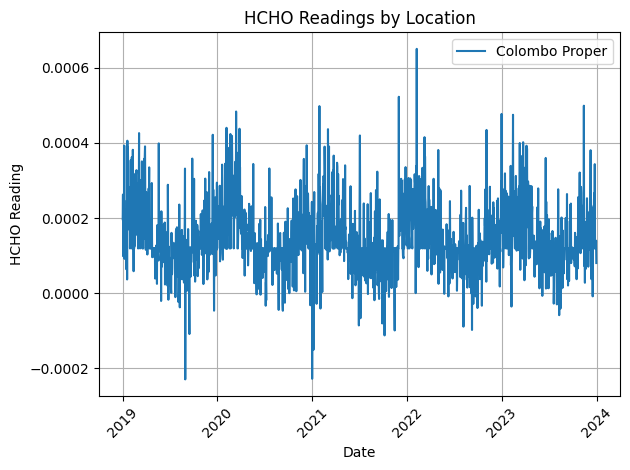

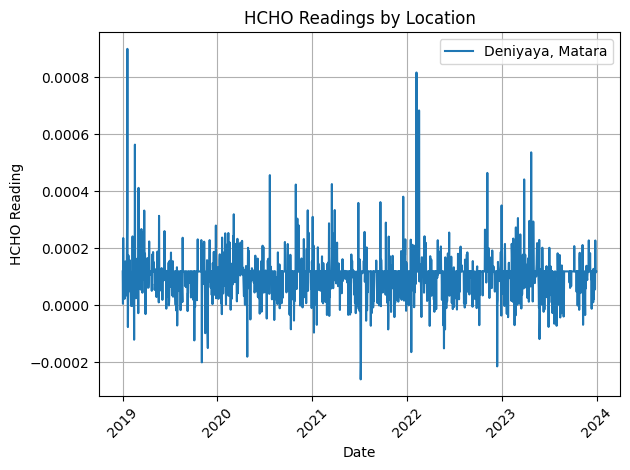

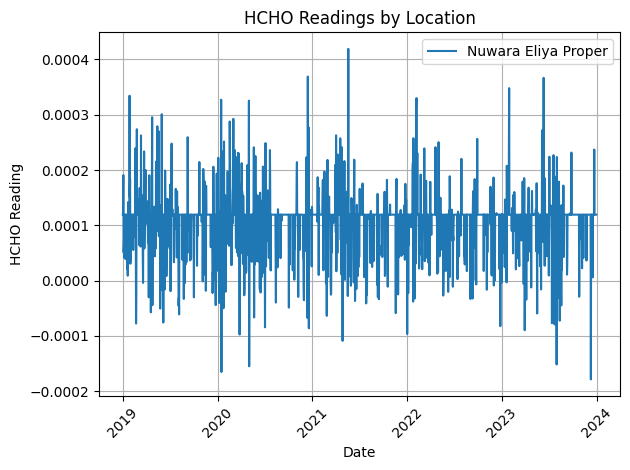

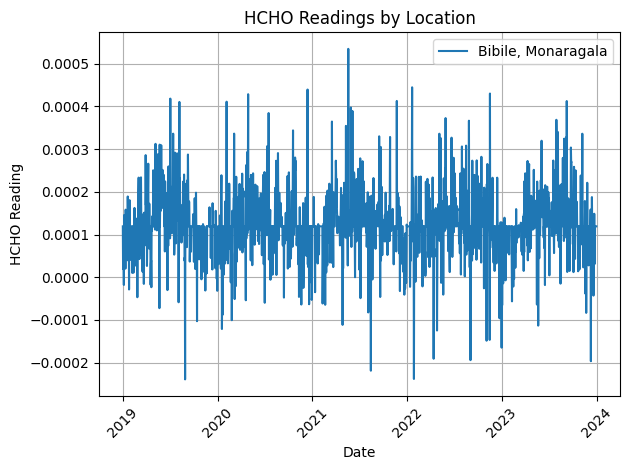

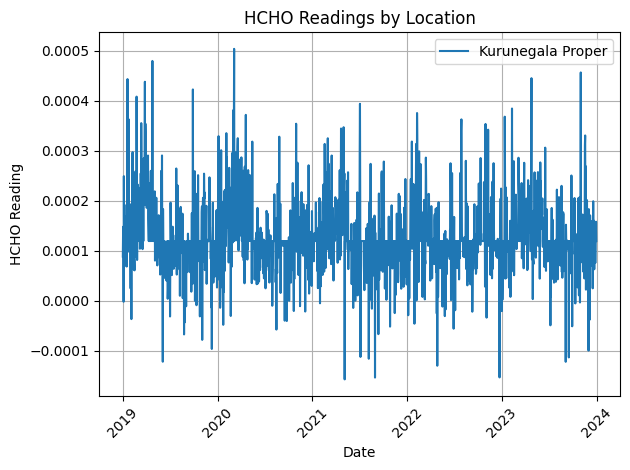

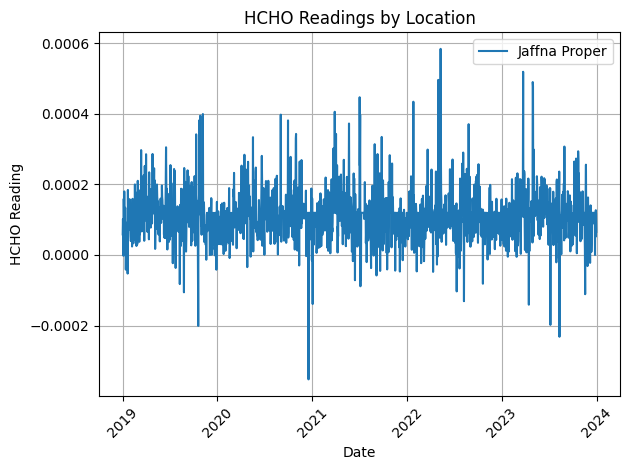

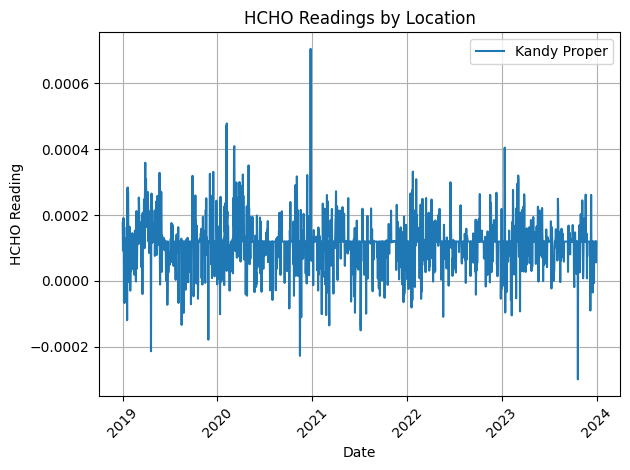

In [ ]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pandas = df_spark.toPandas()

# Plot HCHO readings for each location
locations = df_pandas['Location'].unique()
for location in locations:
    data_location = df_pandas[df_pandas['Location'] == location]
    plt.plot(data_location['Current Date'], data_location['HCHO Reading'], label=location)

    # Customize plot
    plt.xlabel('Date')
    plt.ylabel('HCHO Reading')
    plt.title('HCHO Readings by Location')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    # Show plot
    plt.show()

In [ ]:
# Convert 'Current Date' column to datetime format
df_pandas['Current Date'] = pd.to_datetime(df_pandas['Current Date'])

# Extract month from 'Current Date' column
df_pandas['Month'] = df_pandas['Current Date'].dt.month

# Display the first few rows to verify the changes
print(df_pandas.head())

   HCHO Reading        Location Current Date   Next Date  Month
0      0.000197  Colombo Proper   2019-01-01  2019-01-02      1
1      0.000263  Colombo Proper   2019-01-02  2019-01-03      1
2      0.000099  Colombo Proper   2019-01-03  2019-01-04      1
3      0.000210  Colombo Proper   2019-01-04  2019-01-05      1
4      0.000179  Colombo Proper   2019-01-05  2019-01-06      1


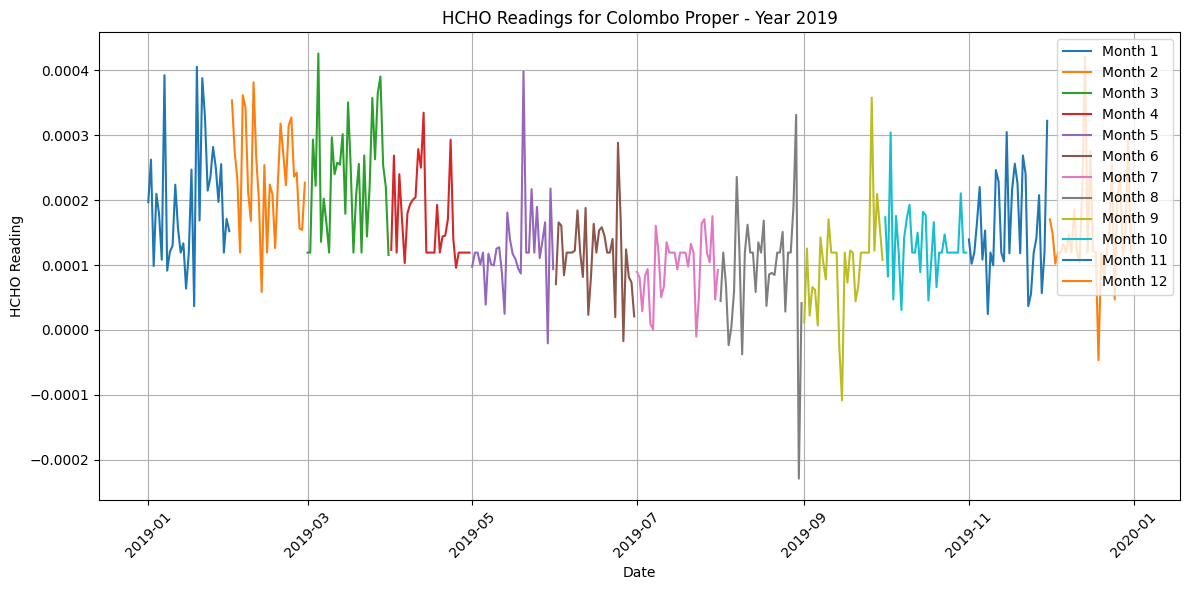

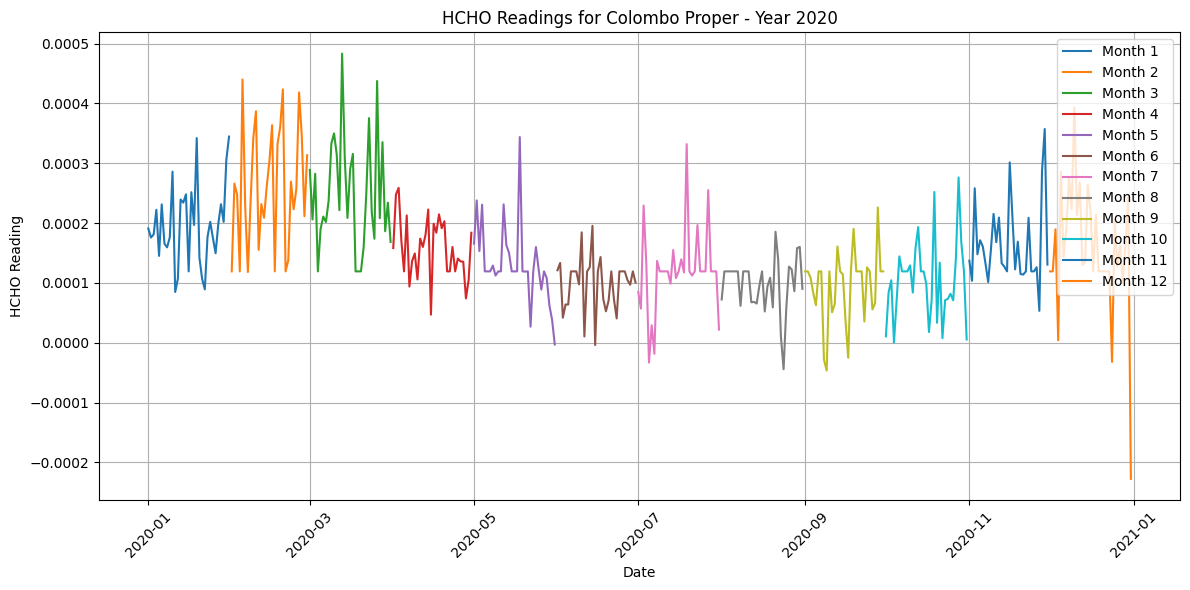

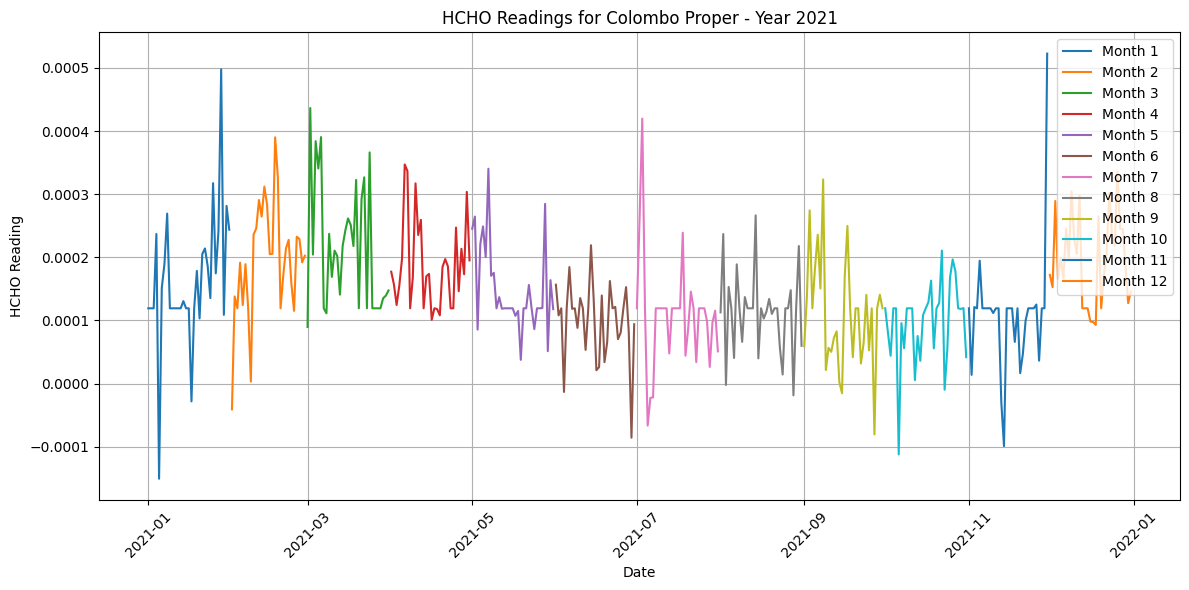

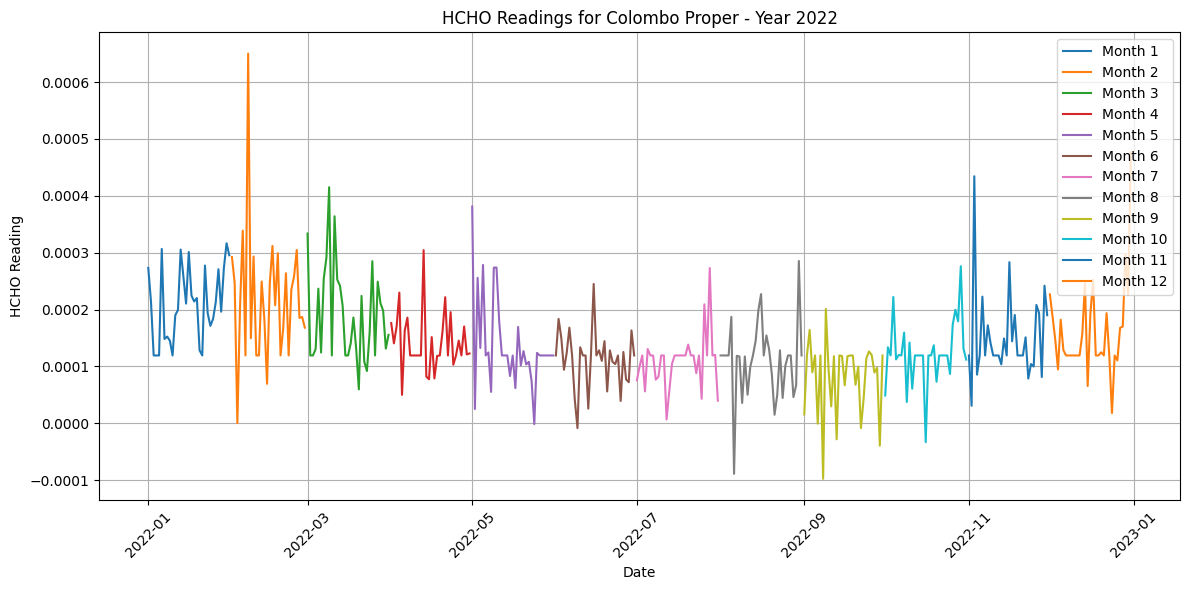

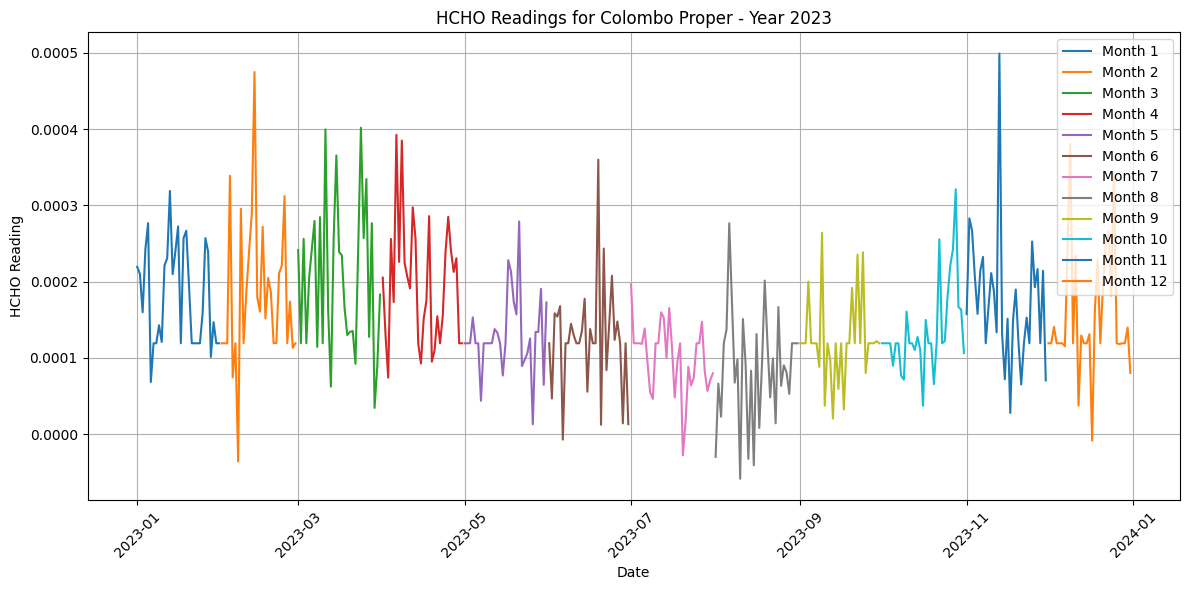

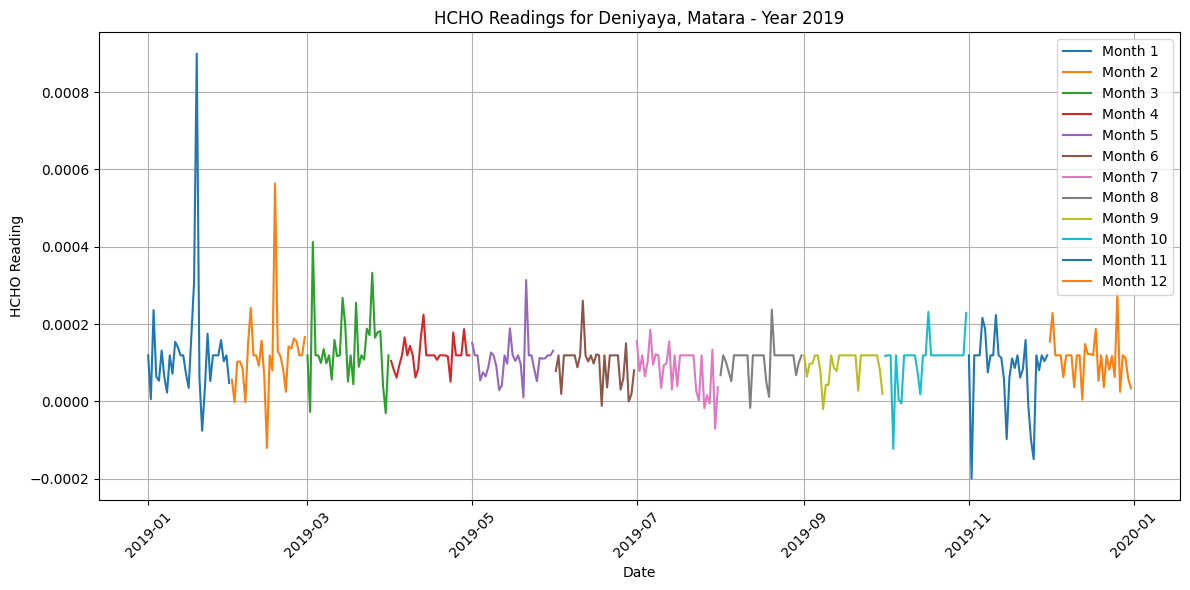

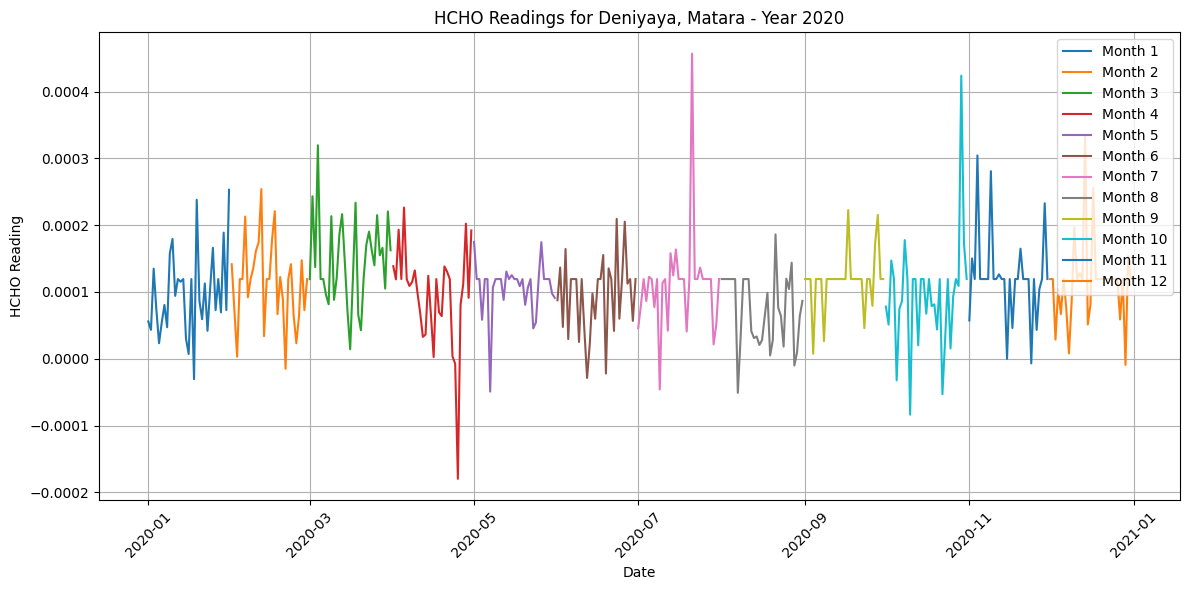

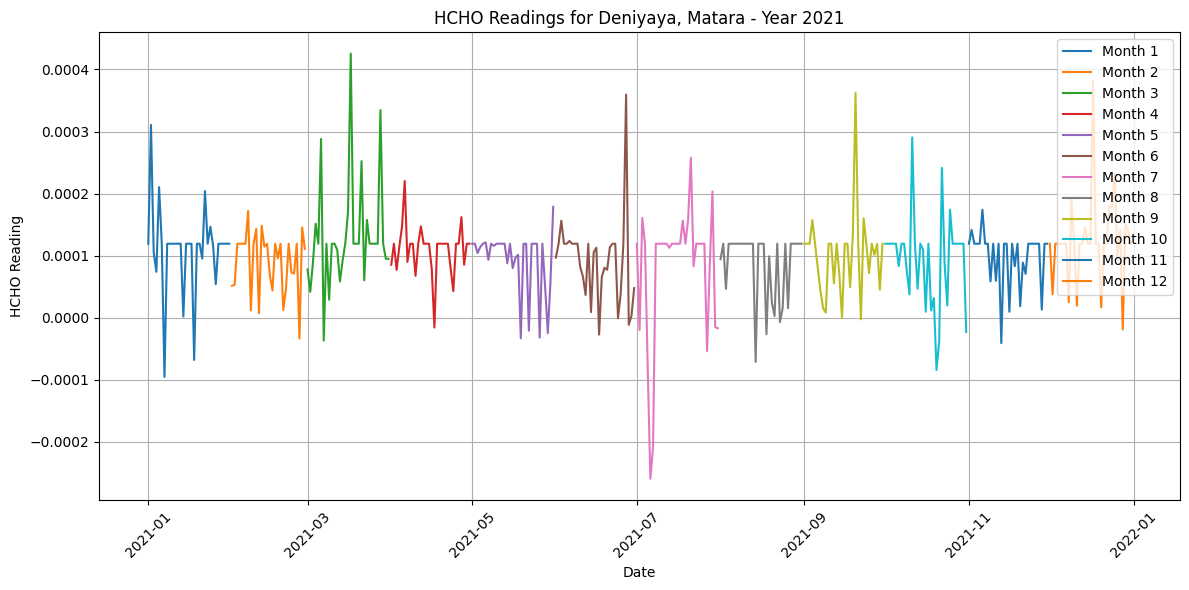

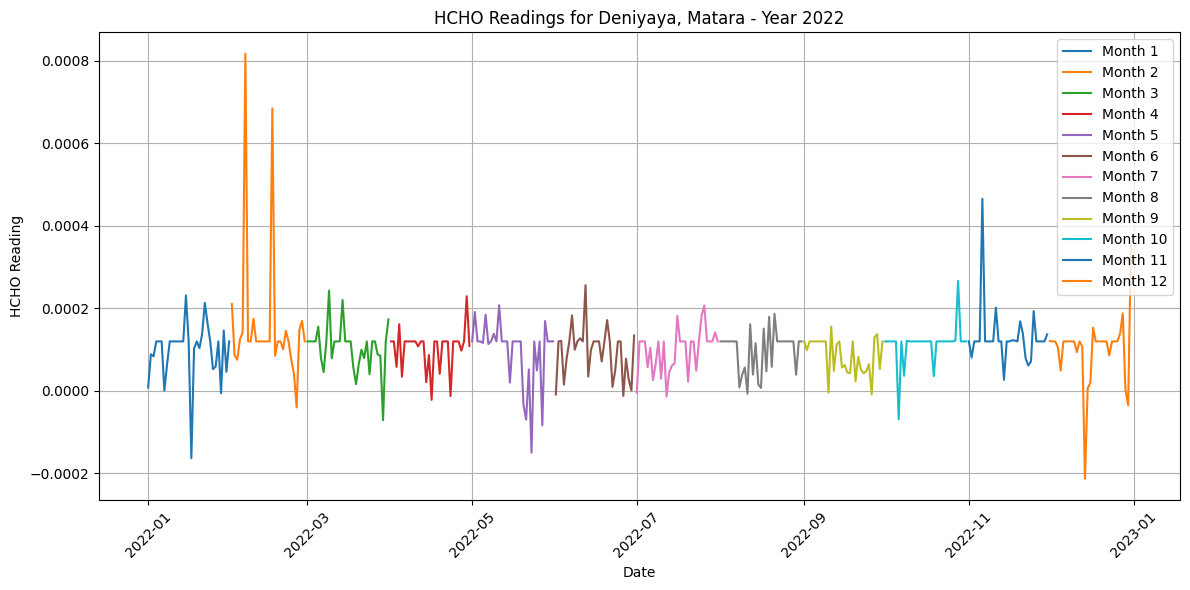

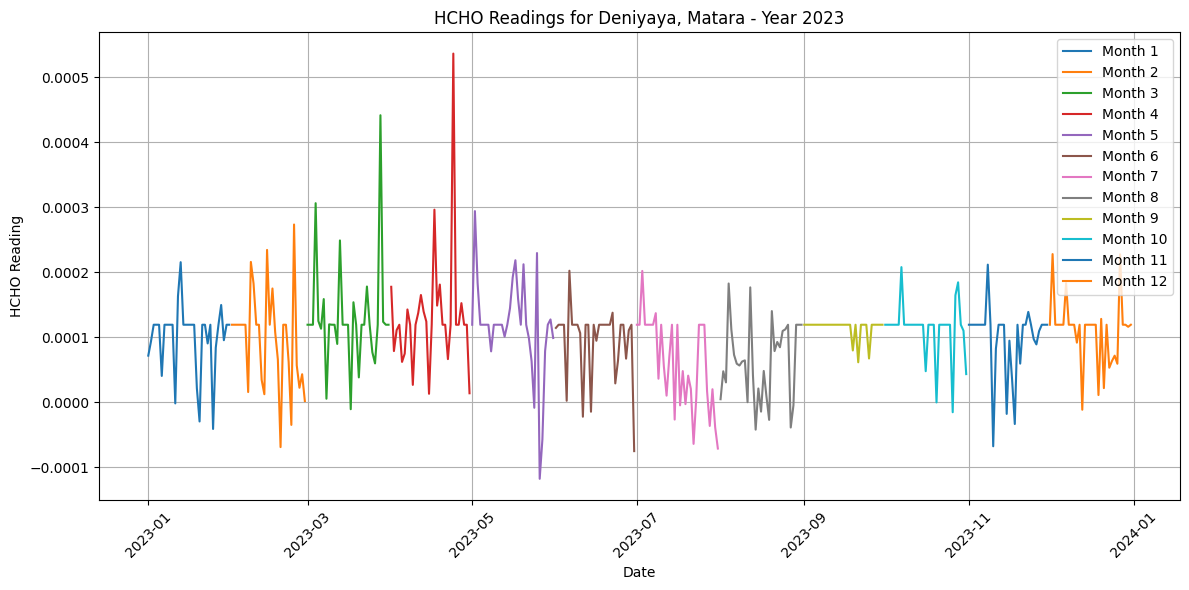

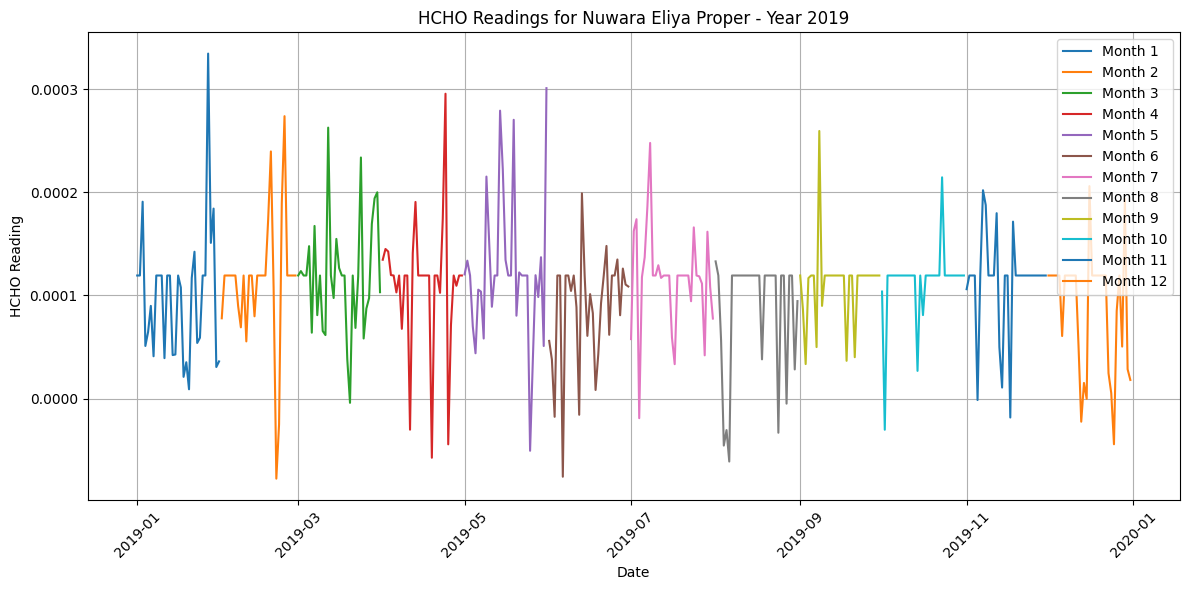

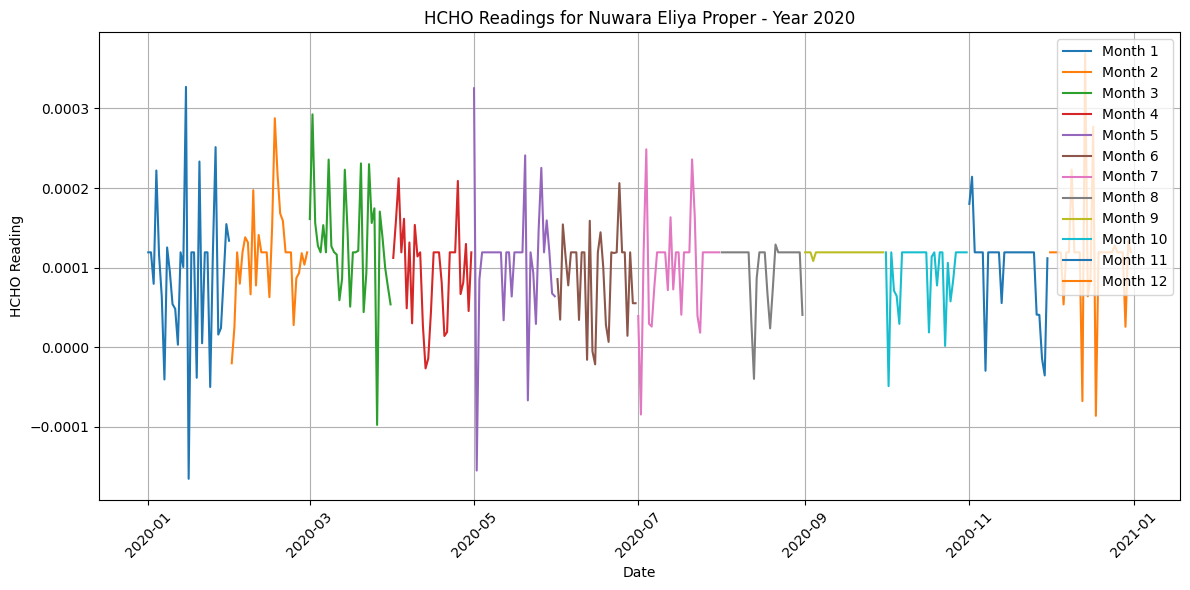

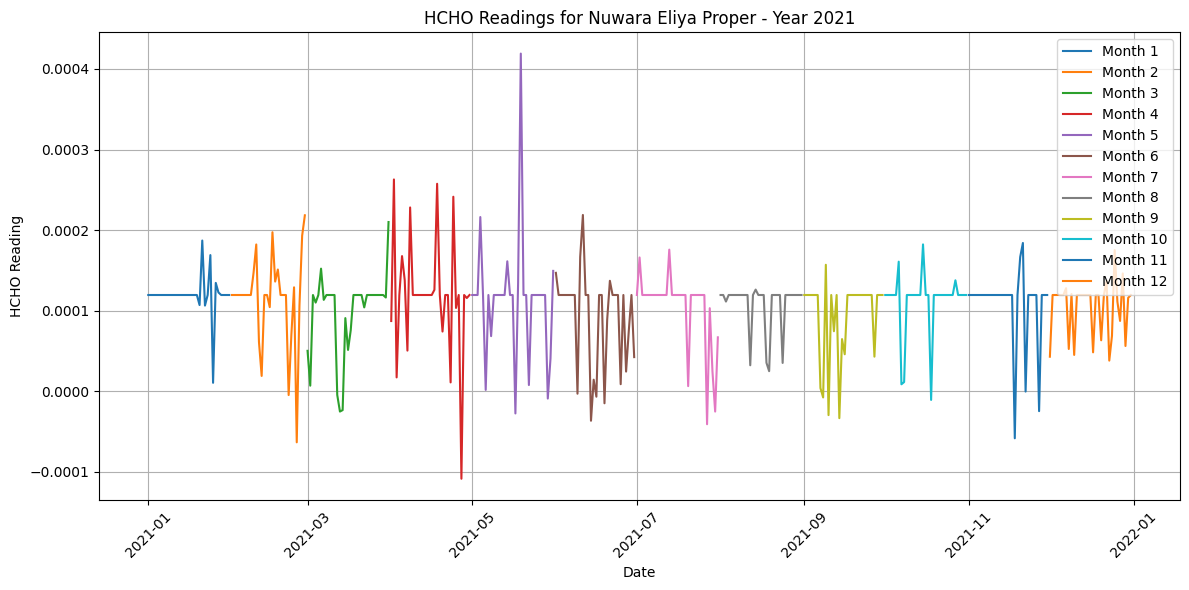

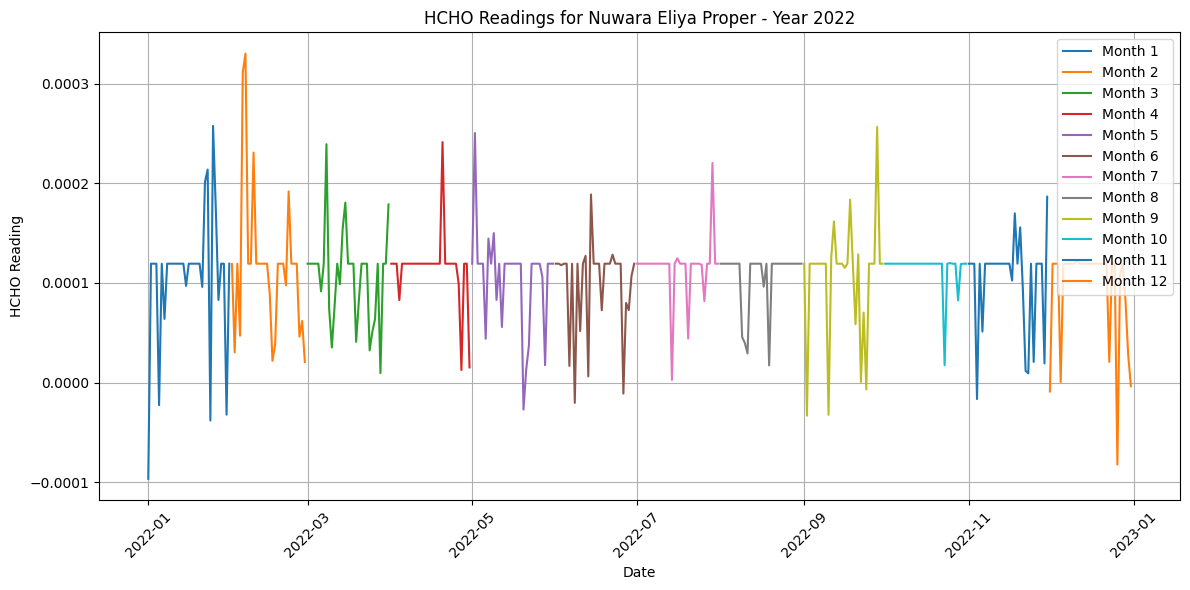

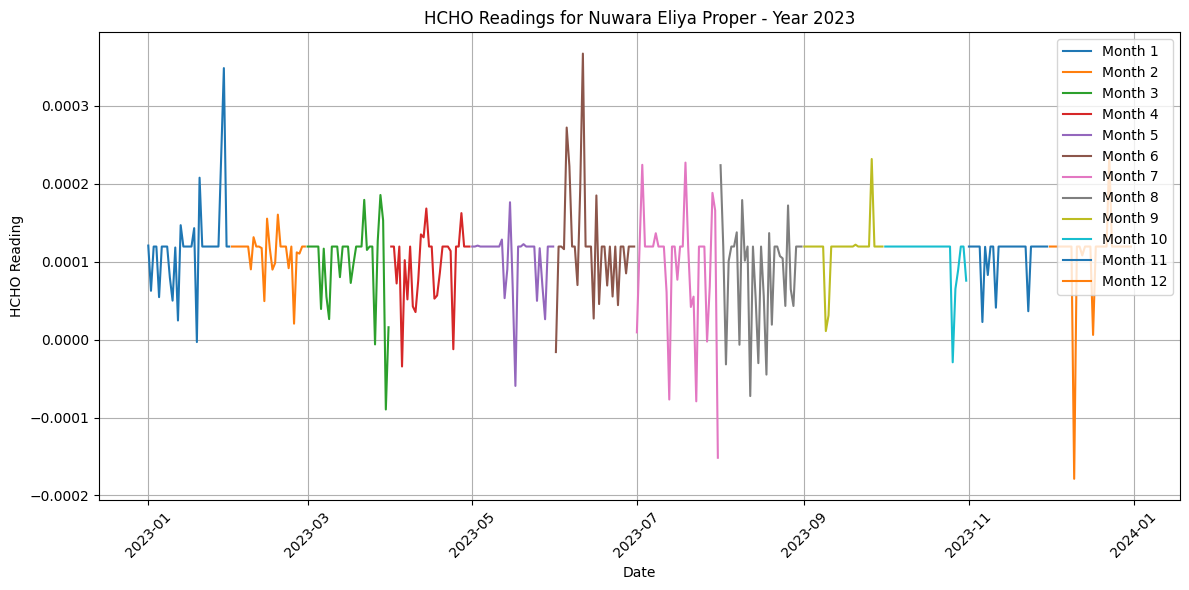

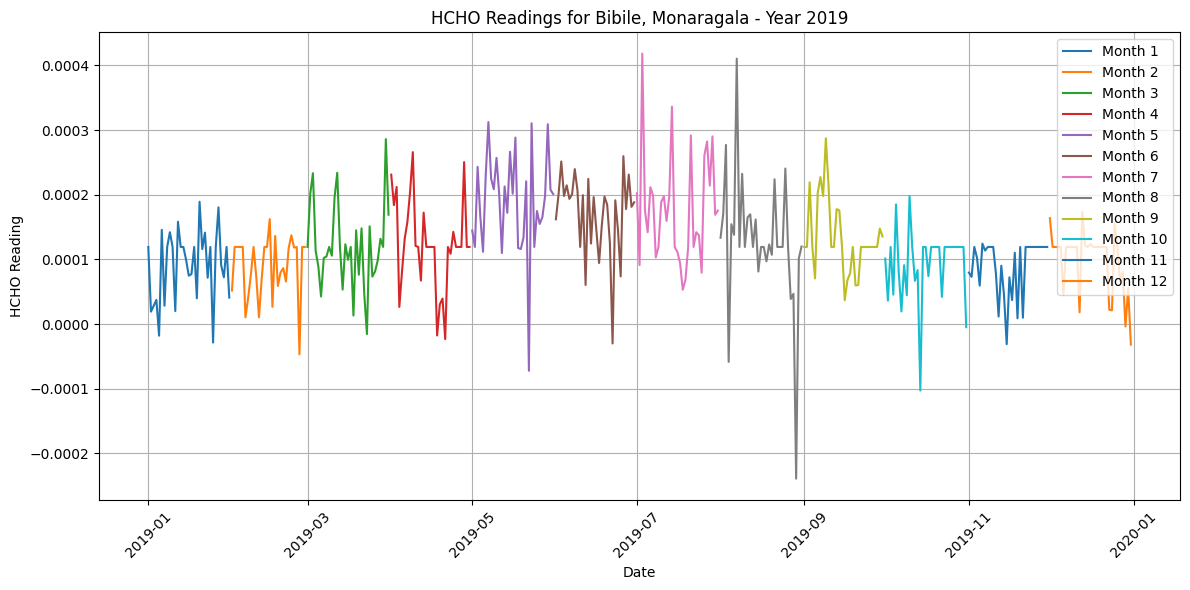

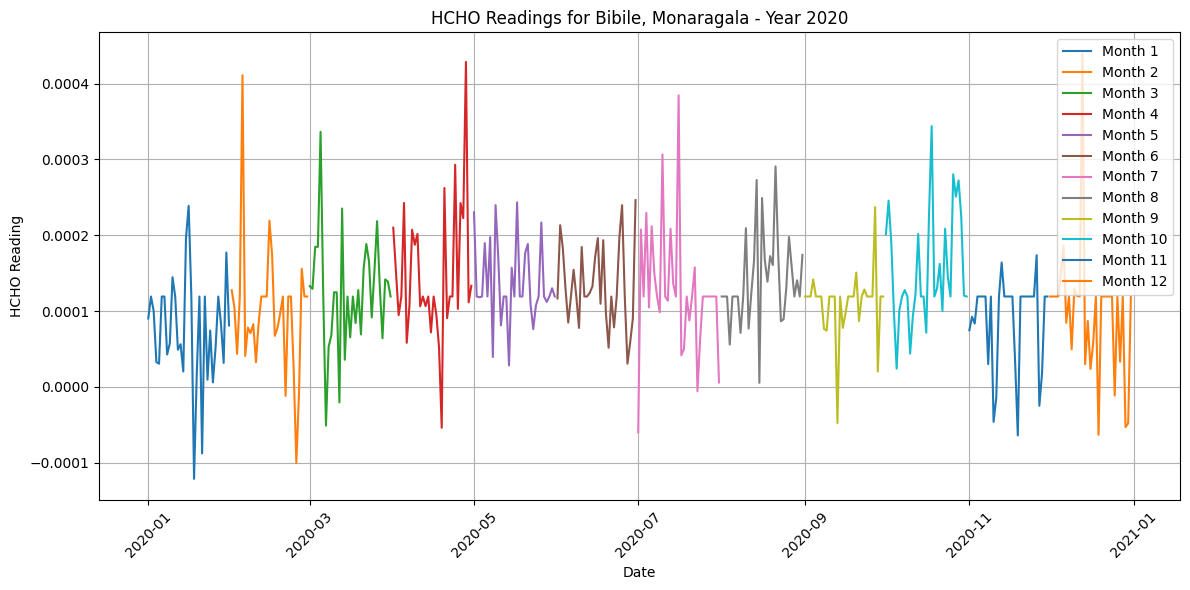

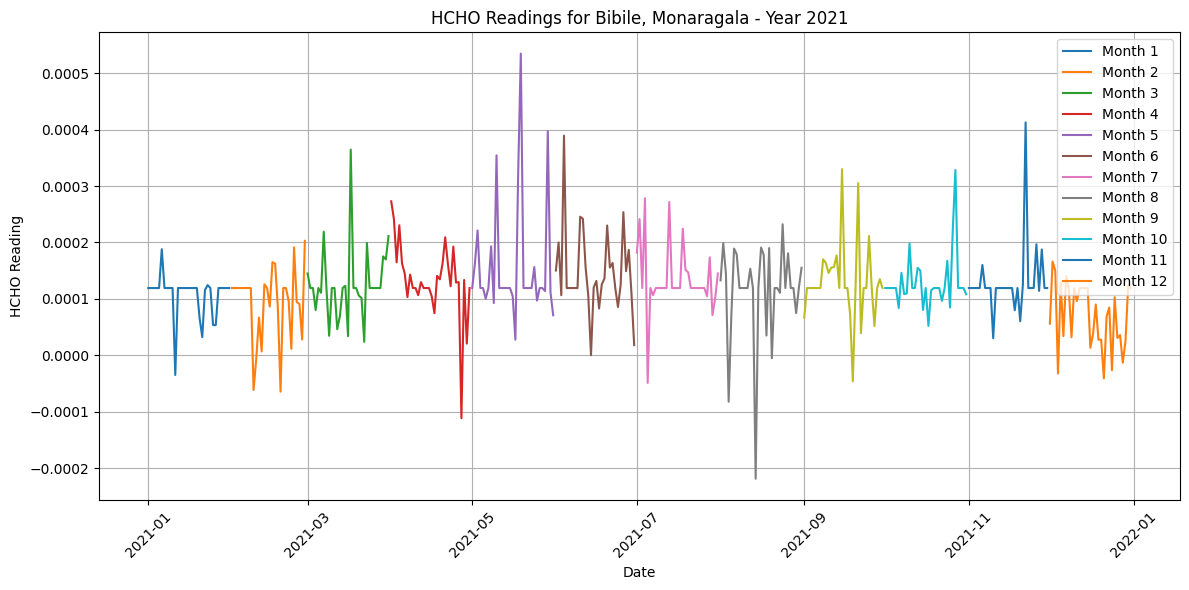

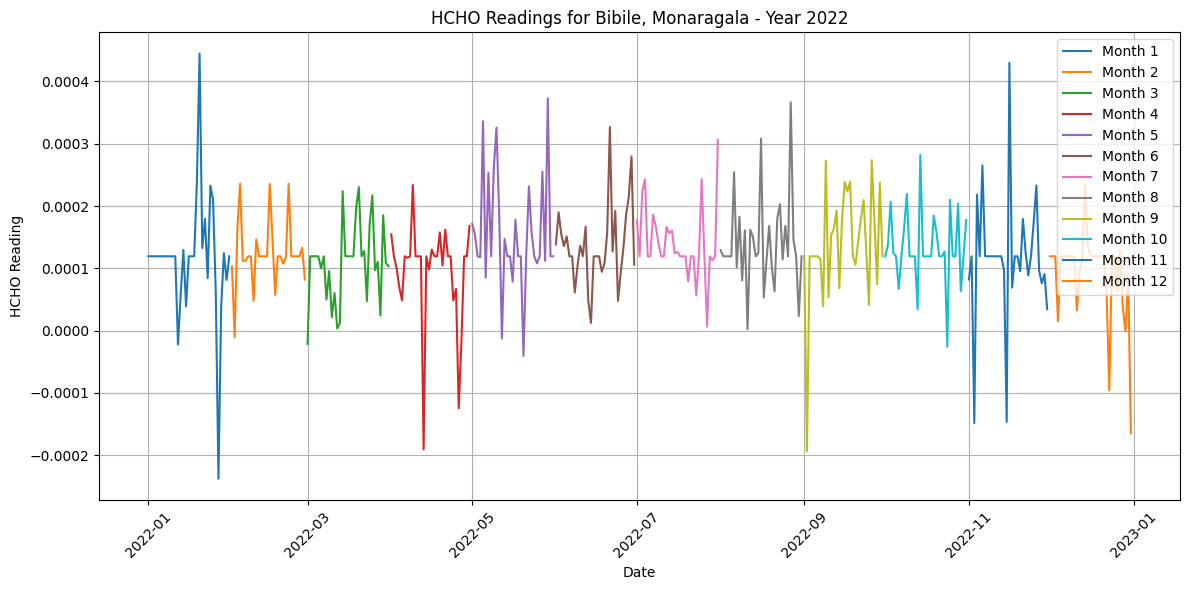

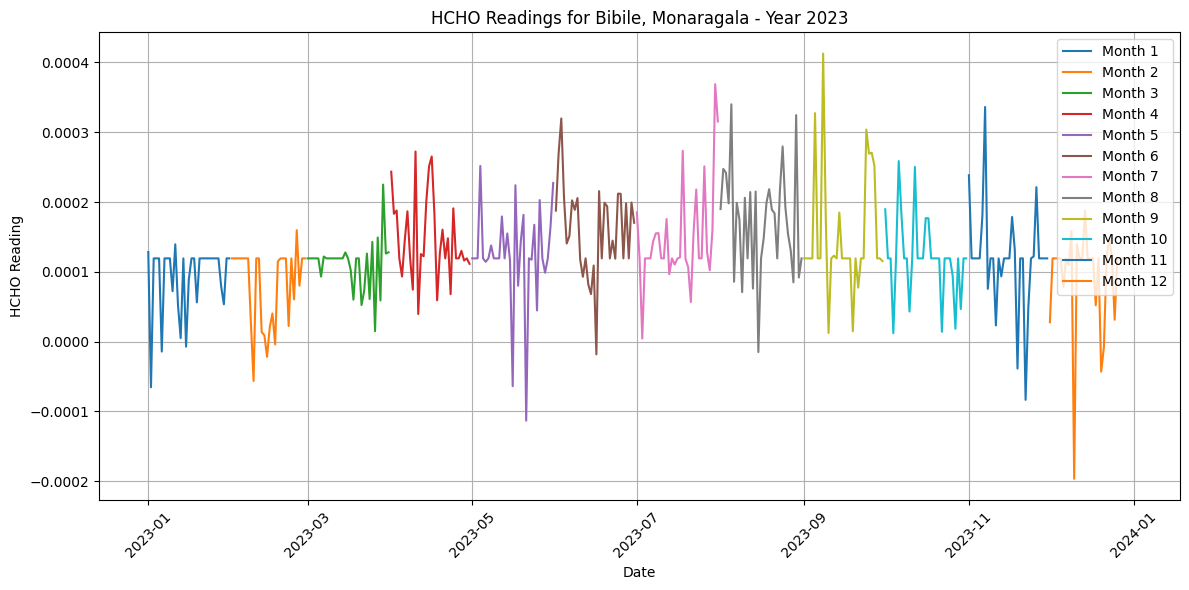

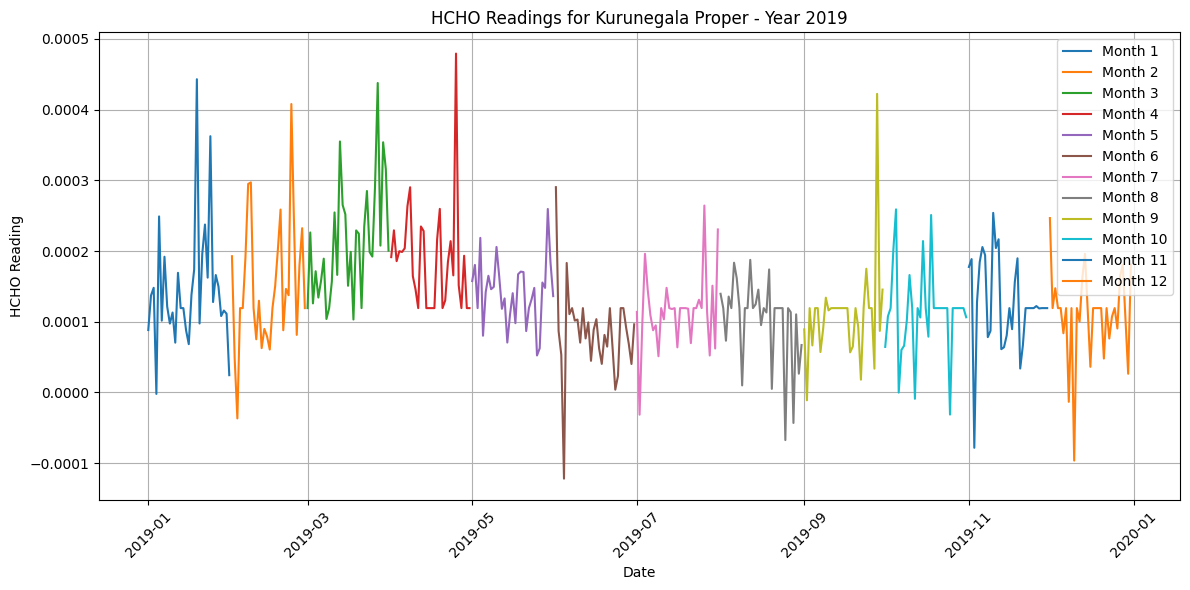

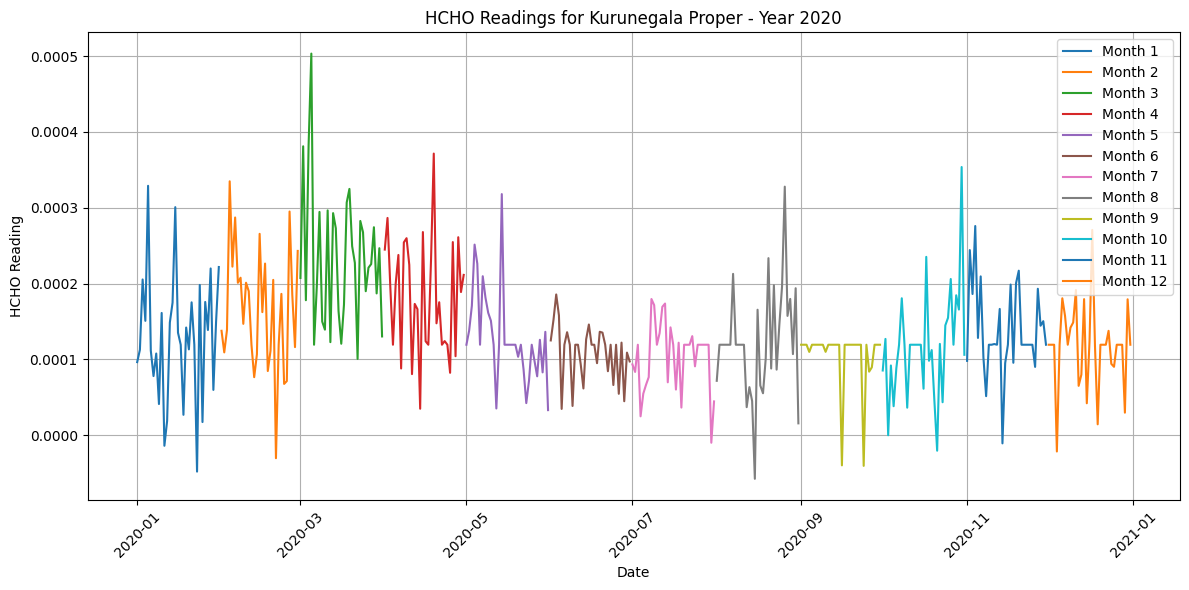

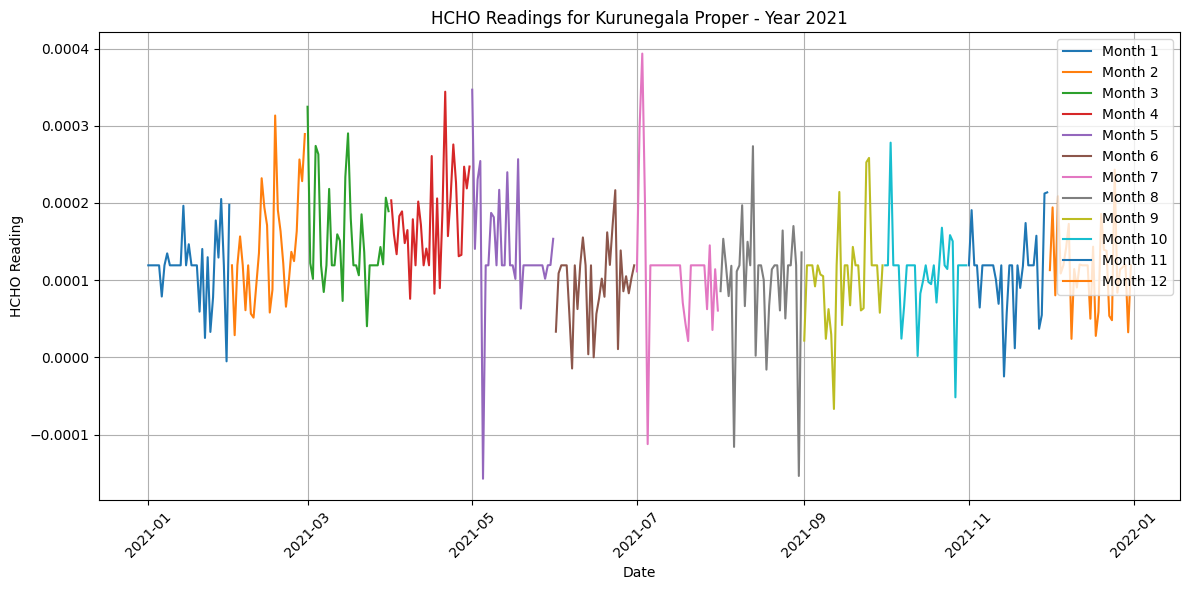

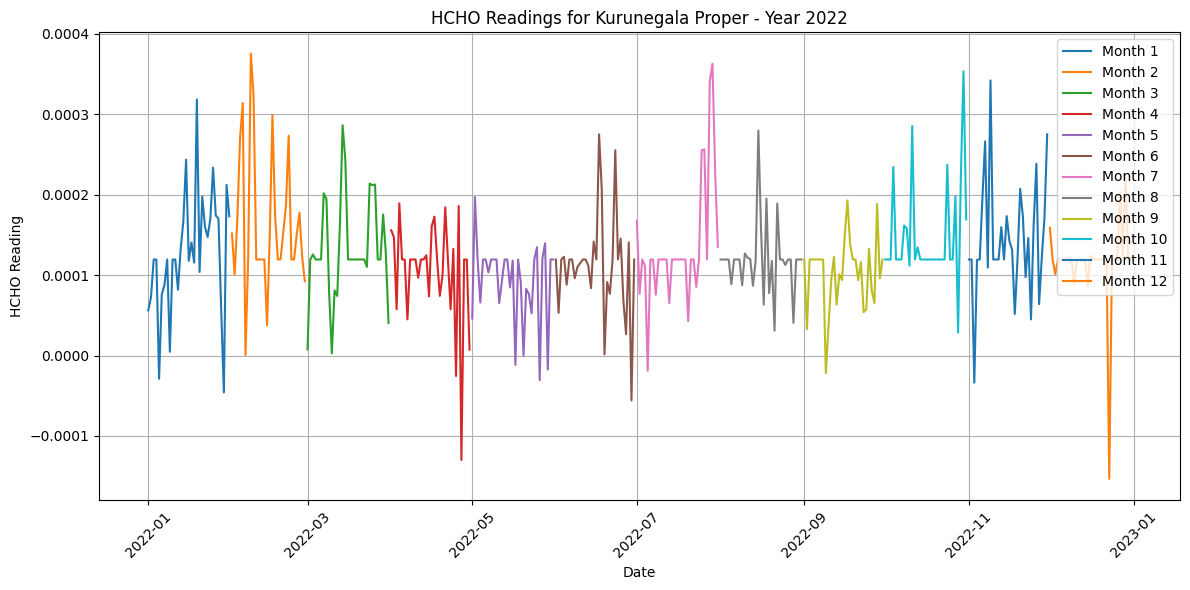

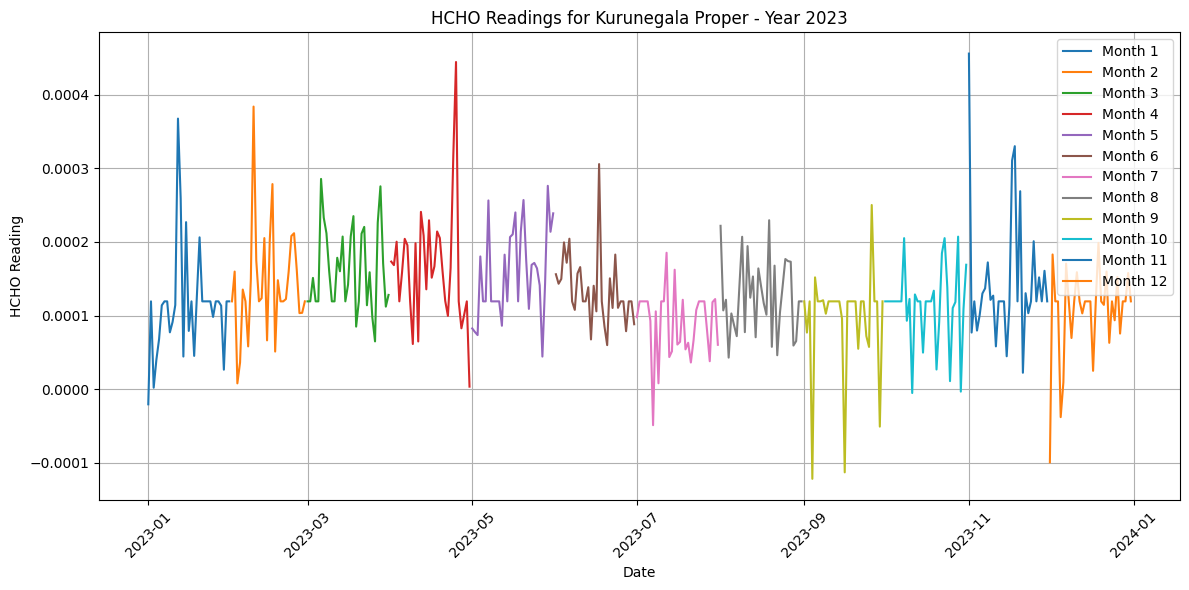

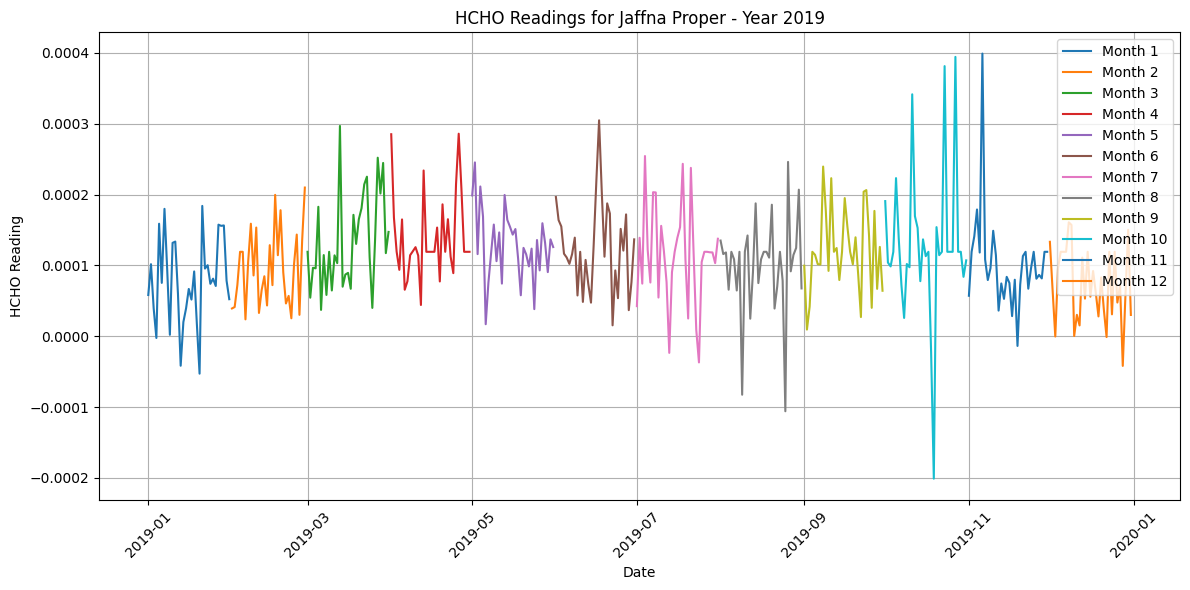

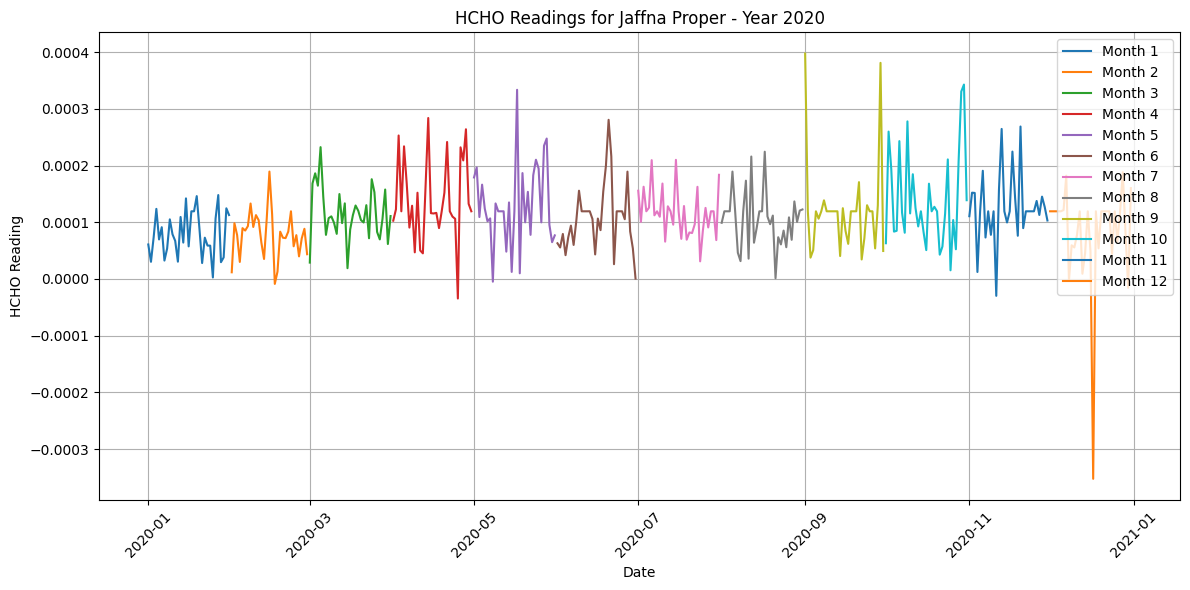

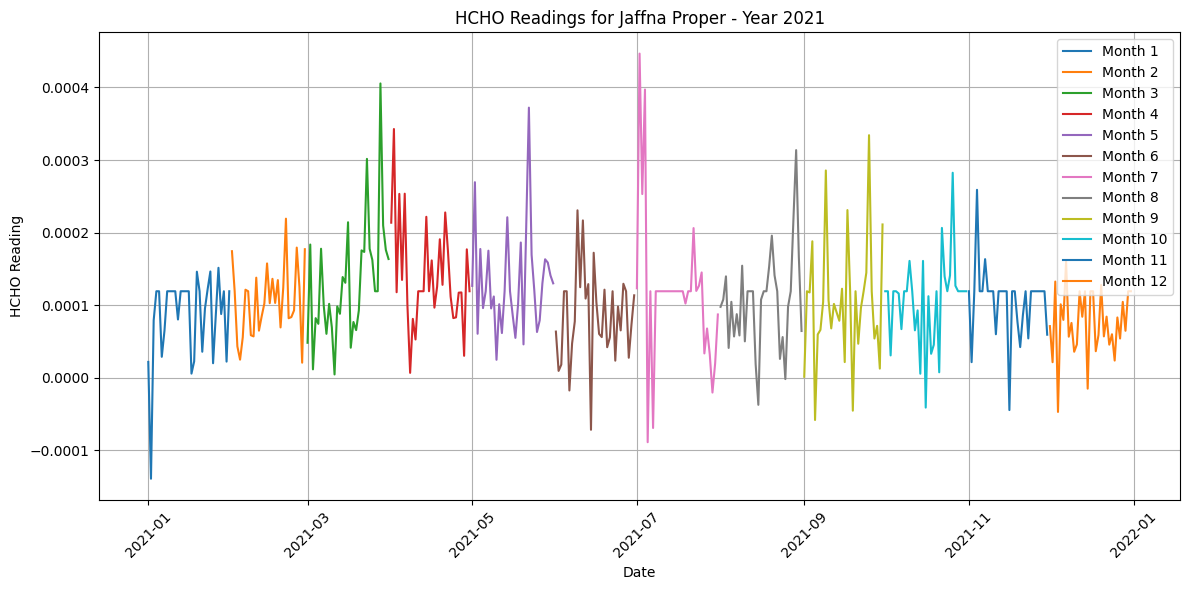

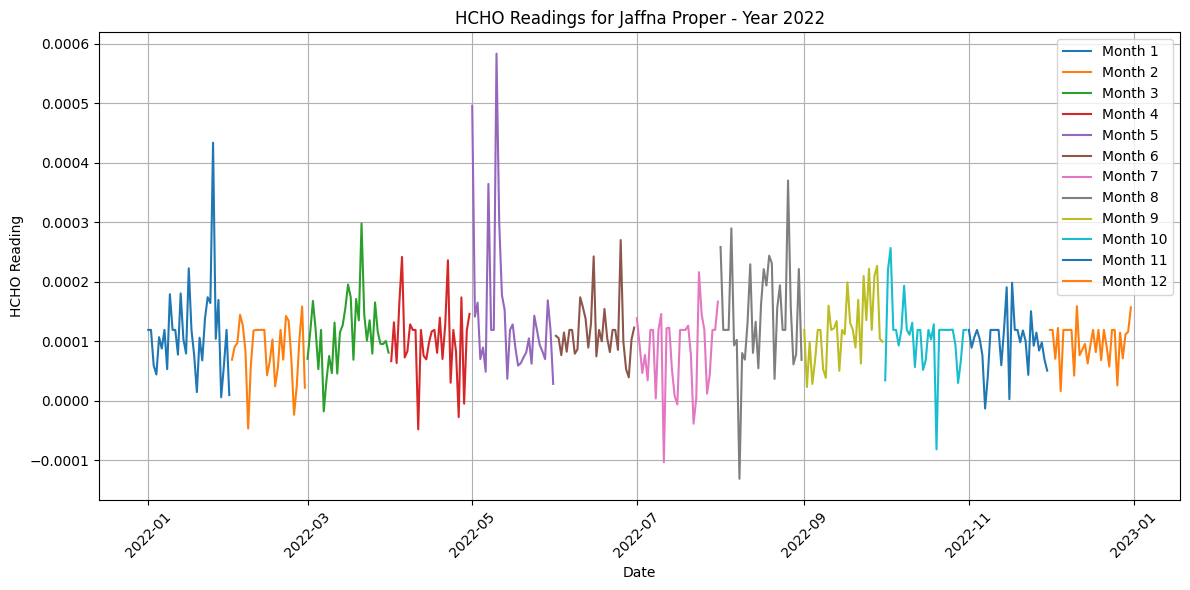

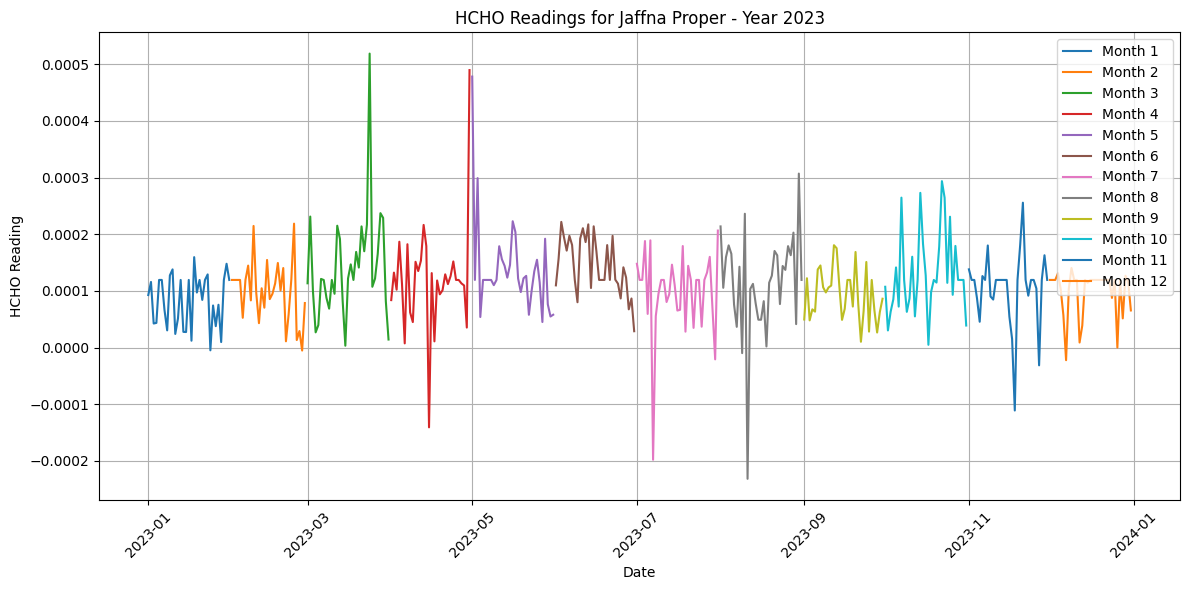

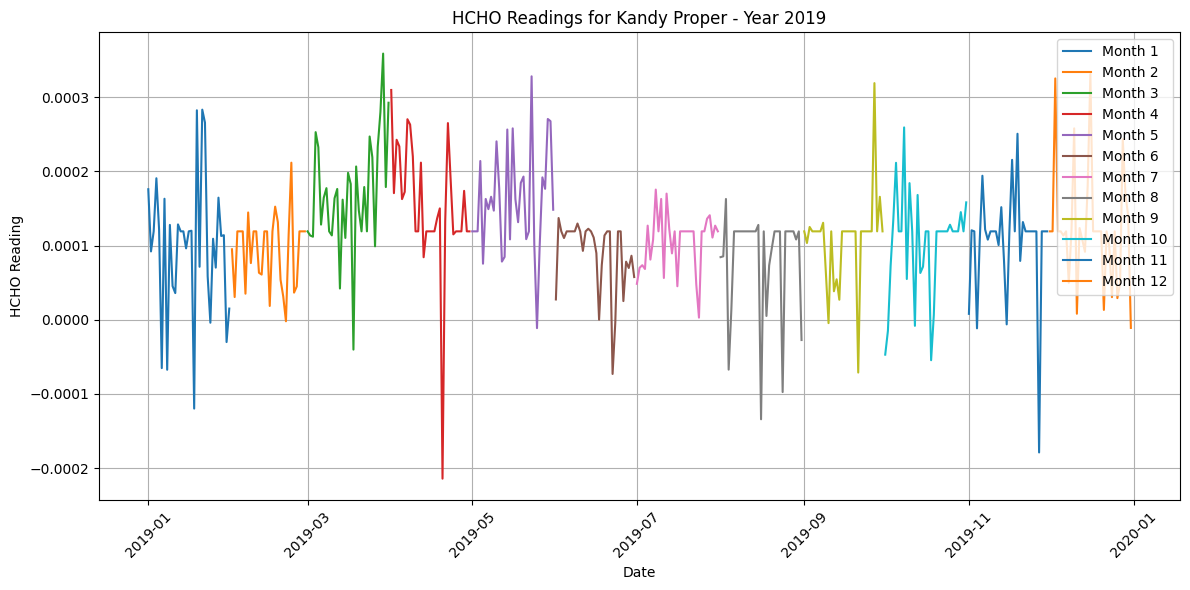

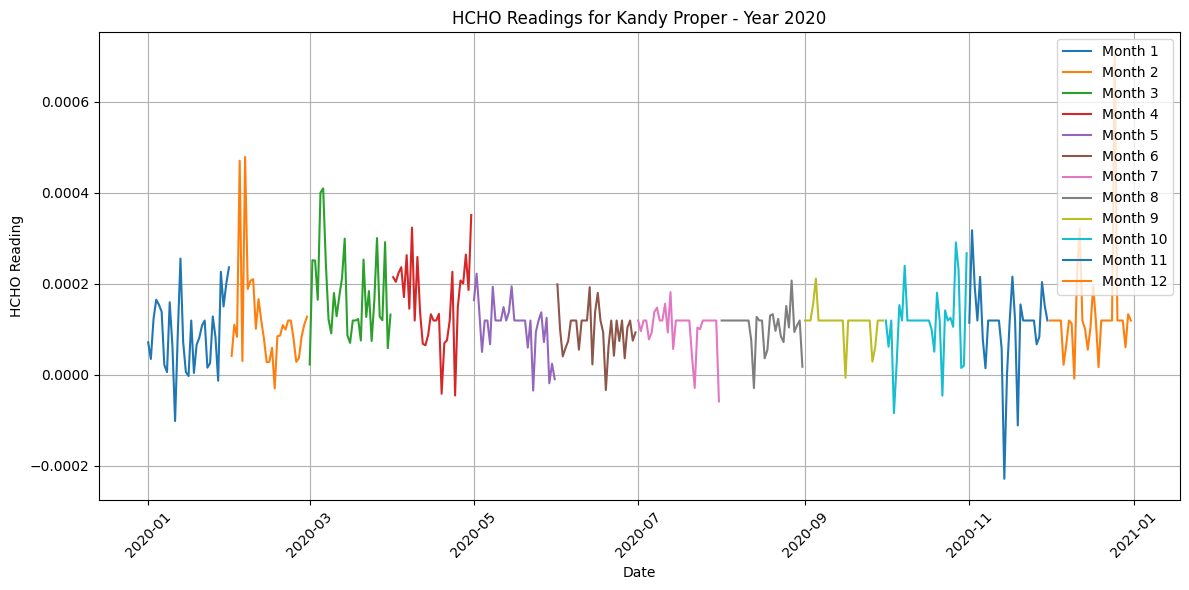

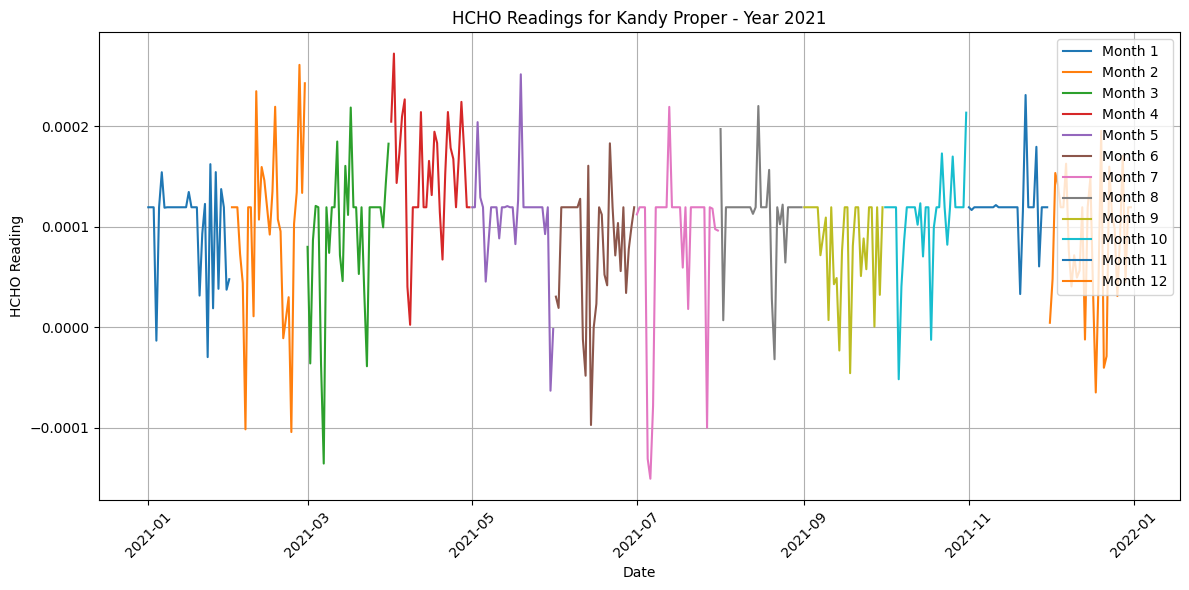

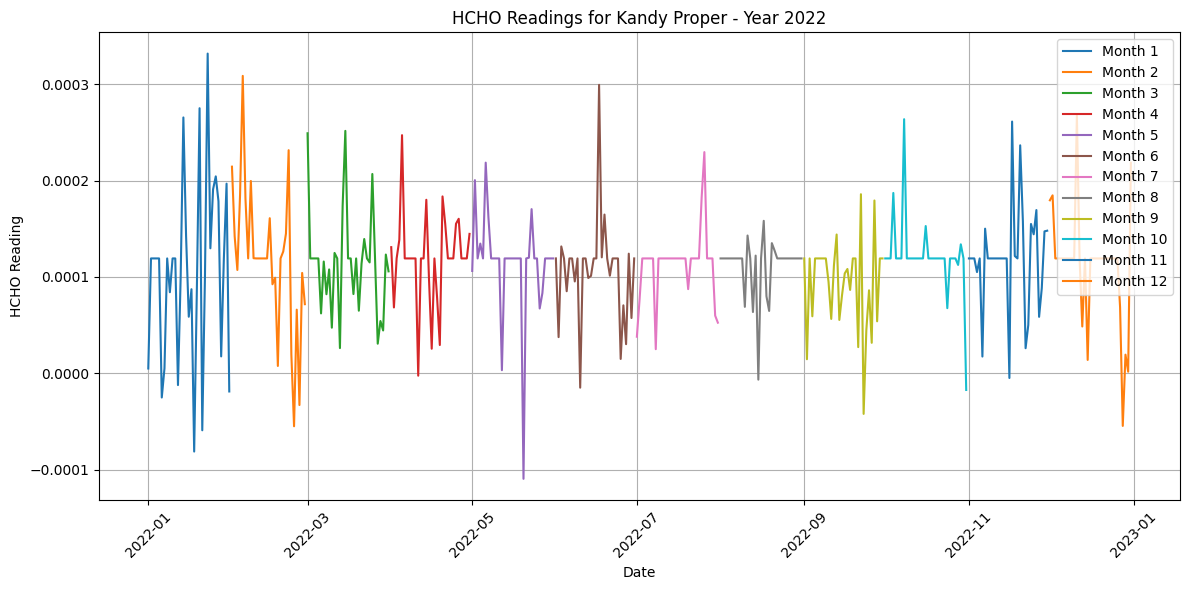

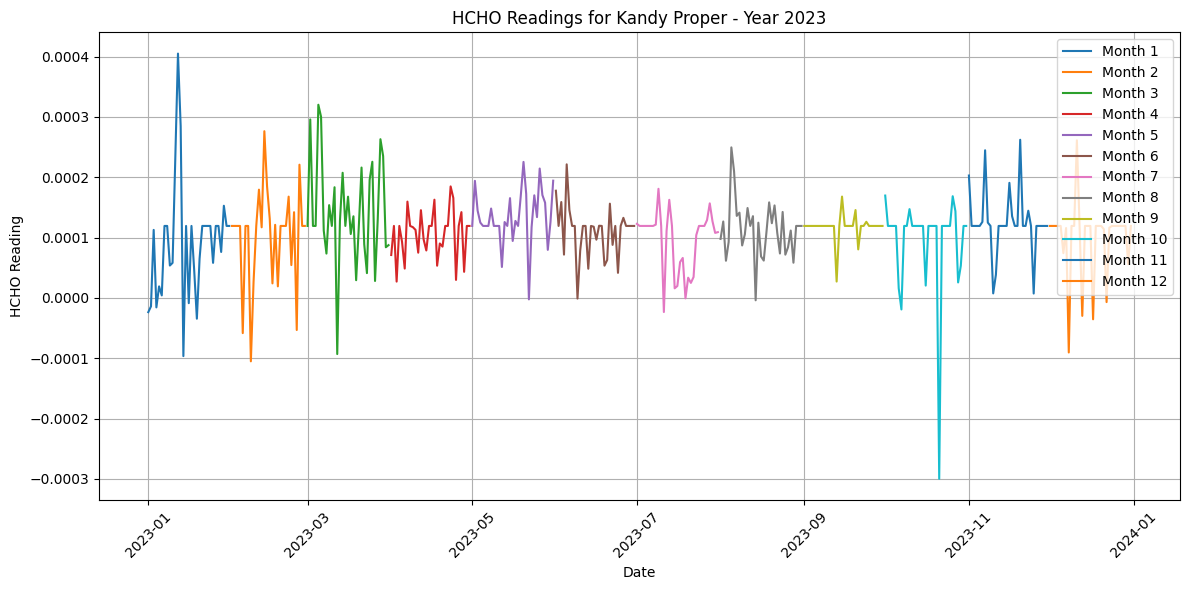

In [ ]:
# Plot HCHO readings for each location and each month
locations = df_pandas['Location'].unique()
months = sorted(df_pandas['Month'].unique())
years = df_pandas['Current Date'].dt.year.unique()

for location in locations:





    for year in years:




        plt.figure(figsize=(12, 6))  # Set the width and height of the plot
        plt.title(f'HCHO Readings for {location} - Year {year}')  # Set the title of the plot






        for month in months:



            data_location_month_year = df_pandas[(df_pandas['Location'] == location) &
                                                  (df_pandas['Month'] == month) &
                                                  (df_pandas['Current Date'].dt.year == year)]



            if not data_location_month_year.empty:
                plt.plot(data_location_month_year['Current Date'], data_location_month_year['HCHO Reading'],
                         label=f"Month {month}")

        # Customize plot
        plt.xlabel('Date')
        plt.ylabel('HCHO Reading')
        plt.legend(loc='upper right')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()

        # Show plot
        plt.show()


In [ ]:
from pyspark.sql.functions import mean, col

# Calculate the mean HCHO reading for each location
mean_hcho_by_location = df_spark.groupBy('Location').agg(mean('HCHO Reading').alias('Mean HCHO Reading'))

# Rank locations based on mean HCHO reading (descending order)
ranked_locations = mean_hcho_by_location.orderBy(col('Mean HCHO Reading').desc())

# Show the ranked locations
ranked_locations.show()

+-------------------+--------------------+
|           Location|   Mean HCHO Reading|
+-------------------+--------------------+
|     Colombo Proper|1.480916996036323...|
|  Kurunegala Proper|1.292407039248092...|
| Bibile, Monaragala|1.237086665854354...|
|       Kandy Proper|1.119791209506632E-4|
|      Jaffna Proper|1.109013636756122...|
|Nuwara Eliya Proper|1.065550795445532...|
|   Deniyaya, Matara|1.044686072749091...|
+-------------------+--------------------+



###**Altitude ?**

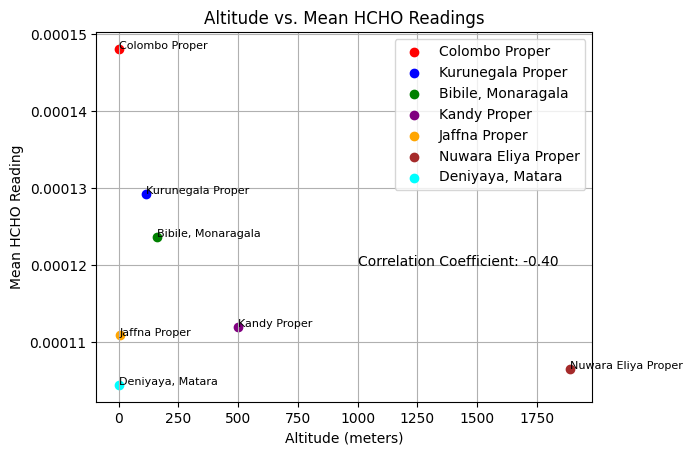

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Altitude data (in meters above sea level) for each location
location_altitude_meters = {

    "Colombo Proper": 1,
    "Kurunegala Proper": 116,
    "Bibile, Monaragala": 161,
    "Kandy Proper": 500,
    "Jaffna Proper": 5,
    "Nuwara Eliya Proper": 1889,
    "Deniyaya, Matara": 2
}

# Mean HCHO reading data for each location
mean_hcho_readings = {

    "Colombo Proper": 1.480916996036323e-4,
    "Kurunegala Proper": 1.292407039248092e-4,
    "Bibile, Monaragala": 1.237086665854354e-4,
    "Kandy Proper": 1.119791209506632e-4,
    "Jaffna Proper": 1.109013636756122e-4,
    "Nuwara Eliya Proper": 1.065550795445532e-4,
    "Deniyaya, Matara": 1.044686072749091e-4
}

# Convert dictionaries to arrays for easier computation
altitudes = np.array(list(location_altitude_meters.values()))
hcho_readings = np.array(list(mean_hcho_readings.values()))
cities = list(location_altitude_meters.keys())  # List of city names

# Calculate correlation coefficient between altitude and mean HCHO readings
correlation_coefficient = np.corrcoef(altitudes, hcho_readings)[0, 1]

# Define colors for each city
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan']

# Plot altitude vs. mean HCHO readings with labeled points
for i in range(len(altitudes)):
    plt.scatter(altitudes[i], hcho_readings[i], color=colors[i], label=cities[i])
    plt.text(altitudes[i], hcho_readings[i], cities[i], fontsize=8)

plt.title('Altitude vs. Mean HCHO Readings')
plt.xlabel('Altitude (meters)')
plt.ylabel('Mean HCHO Reading')
plt.grid(True)

# Add legend
plt.legend(loc='upper right')

# Add correlation coefficient to the plot
plt.text(1000, 1.2e-4, f'Correlation Coefficient: {correlation_coefficient:.2f}', fontsize=10, color='black')

# Show plot
plt.show()


###**Population Density ?**

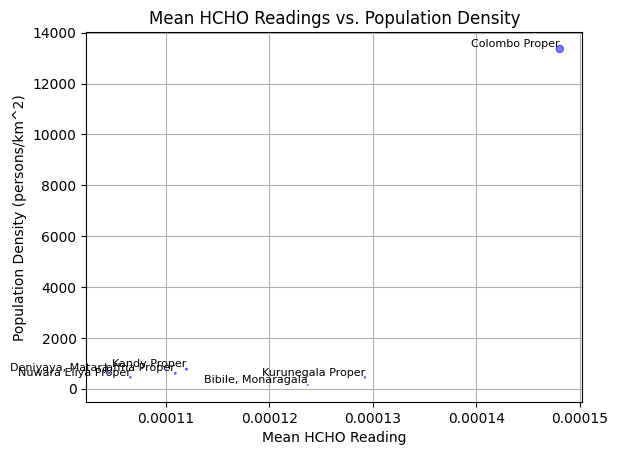

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Mean HCHO reading data for each location
mean_hcho_readings = {
    "Colombo Proper": 1.480916996036323e-4,
    "Kurunegala Proper": 1.292407039248092e-4,
    "Bibile, Monaragala": 1.237086665854354e-4,
    "Kandy Proper": 1.119791209506632e-4,
    "Jaffna Proper": 1.109013636756122e-4,
    "Nuwara Eliya Proper": 1.065550795445532e-4,
    "Deniyaya, Matara": 1.044686072749091e-4
}

# Population density data for each location (persons per square kilometer)
population_density = {
    "Colombo Proper": 13364,
    "Kurunegala Proper": 448.02,
    "Bibile, Monaragala": 152,
    "Kandy Proper": 773.2,
    "Jaffna Proper": 610.73,
    "Nuwara Eliya Proper": 448.02,
    "Deniyaya, Matara": 634.59
}

# Convert dictionaries to arrays for easier computation
hcho_readings = np.array(list(mean_hcho_readings.values()))
population_densities = np.array(list(population_density.values()))
cities = list(mean_hcho_readings.keys())  # List of city names

# Define marker sizes based on population density
marker_sizes = population_densities / 500  # Adjust scale for better visualization

# Plot mean HCHO readings vs. population density with marker size
plt.scatter(hcho_readings, population_densities, s=marker_sizes, c='blue', alpha=0.5)

# Display city names separately
for i, city in enumerate(cities):
    plt.text(hcho_readings[i], population_densities[i], city, fontsize=8, ha='right', va='bottom')

plt.title('Mean HCHO Readings vs. Population Density')
plt.xlabel('Mean HCHO Reading')
plt.ylabel('Population Density (persons/km^2)')
plt.grid(True)

# Show plot
plt.show()


#**3. Model Development**

In [ ]:
df_pandas = df_spark.toPandas()
columns_list = df_pandas.columns
print(columns_list)

Index(['HCHO Reading', 'Location', 'Current Date', 'Next Date'], dtype='object')


In [ ]:
!pip install tensorflow

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Function to create sequences for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

In [ ]:
# Normalize the data and handle it for each location
scaler = MinMaxScaler(feature_range=(0, 1))

evaluation_metrics = {}  # Dictionary to store evaluation metrics for each location
results = {}  # Dictionary to store predictions for each location

Processing Colombo Proper...
Epoch 1/50
40/40 [==============================] - 6s 22ms/step - loss: 0.0137
Epoch 2/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0092
Epoch 3/50
40/40 [==============================] - 1s 22ms/step - loss: 0.0088
Epoch 4/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0089
Epoch 5/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0097
Epoch 6/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0089
Epoch 7/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0085
Epoch 8/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0087
Epoch 9/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0090
Epoch 10/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0083
Epoch 11/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0086
Epoch 12/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0089
Epoch 13

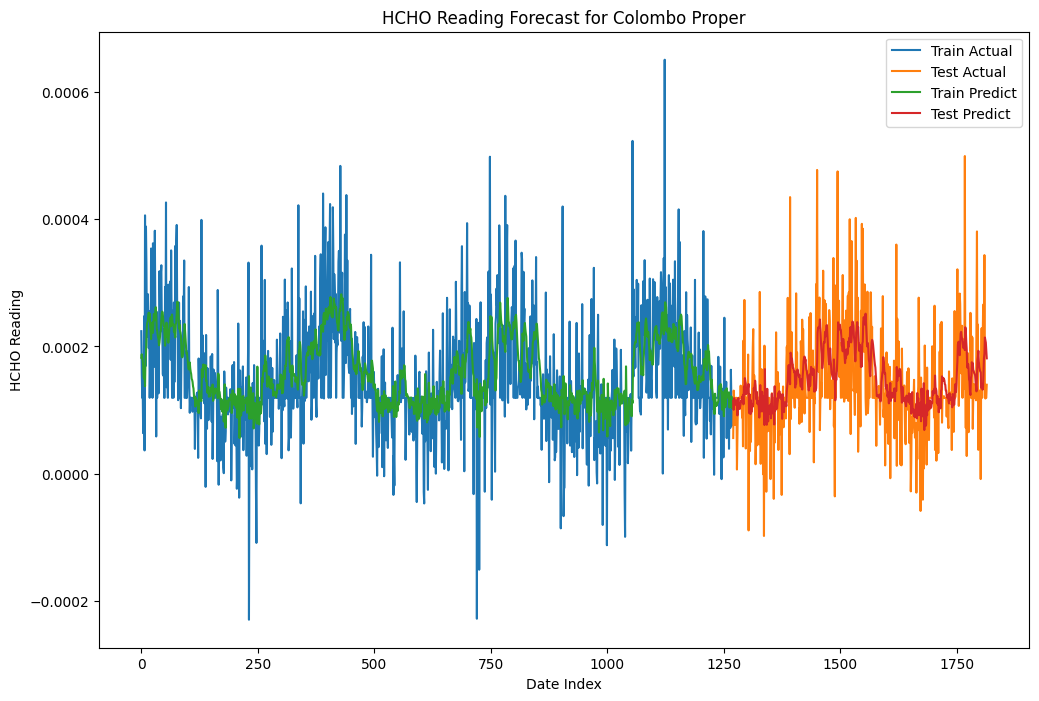

Processing Deniyaya, Matara...
Epoch 1/50
40/40 [==============================] - 6s 14ms/step - loss: 0.0079
Epoch 2/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0046
Epoch 3/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0043
Epoch 4/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0045
Epoch 5/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0042
Epoch 6/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0044
Epoch 7/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0043
Epoch 8/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 9/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0045
Epoch 10/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0043
Epoch 11/50
40/40 [==============================] - 1s 13ms/step - loss: 0.0044
Epoch 12/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0043
Epoch 

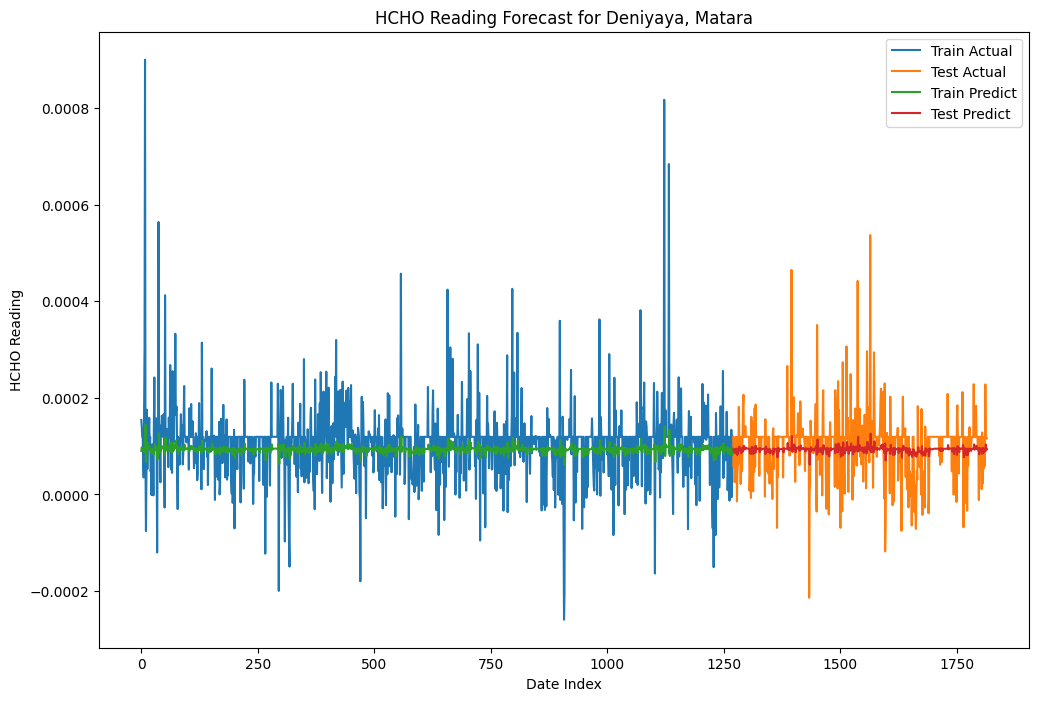

Processing Nuwara Eliya Proper...
Epoch 1/50
40/40 [==============================] - 6s 23ms/step - loss: 0.0390
Epoch 2/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0095
Epoch 3/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0095
Epoch 4/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0096
Epoch 5/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0095
Epoch 6/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0096
Epoch 7/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0094
Epoch 8/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0094
Epoch 9/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0096
Epoch 10/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0094
Epoch 11/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0094
Epoch 12/50
40/40 [==============================] - 1s 14ms/step - loss: 0.0094
Epo

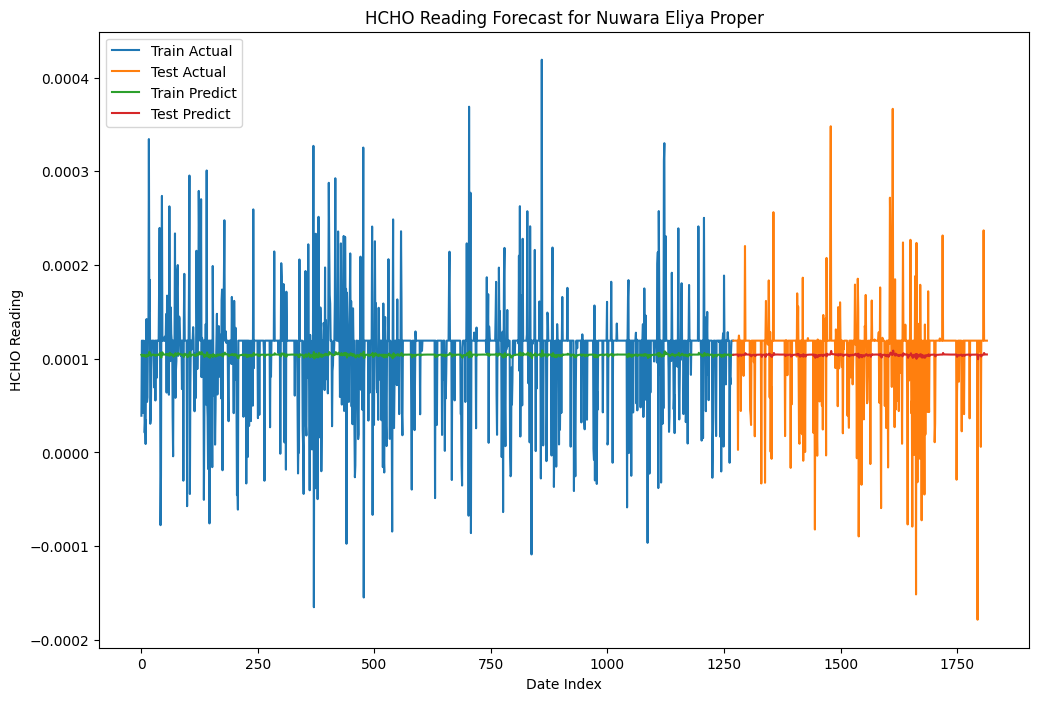

Processing Bibile, Monaragala...
Epoch 1/50
40/40 [==============================] - 11s 19ms/step - loss: 0.0170
Epoch 2/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 3/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0091
Epoch 4/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0090
Epoch 5/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0091
Epoch 6/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0091
Epoch 7/50
40/40 [==============================] - 1s 21ms/step - loss: 0.0093
Epoch 8/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0093
Epoch 9/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0094
Epoch 10/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0090
Epoch 11/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0091
Epoch 12/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0095
Epo

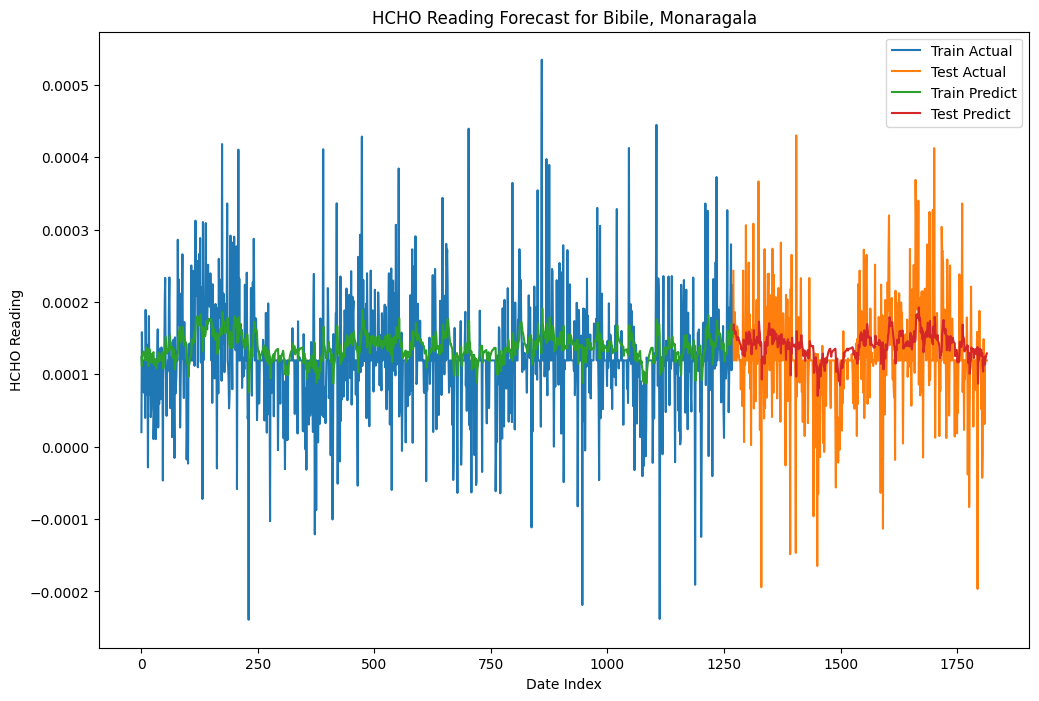

Processing Kurunegala Proper...
Epoch 1/50
40/40 [==============================] - 5s 21ms/step - loss: 0.0225
Epoch 2/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0115
Epoch 3/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0115
Epoch 4/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0121
Epoch 5/50
40/40 [==============================] - 1s 28ms/step - loss: 0.0114
Epoch 6/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0112
Epoch 7/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0114
Epoch 8/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0114
Epoch 9/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0115
Epoch 10/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0112
Epoch 11/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0118
Epoch 12/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0116
Epoch

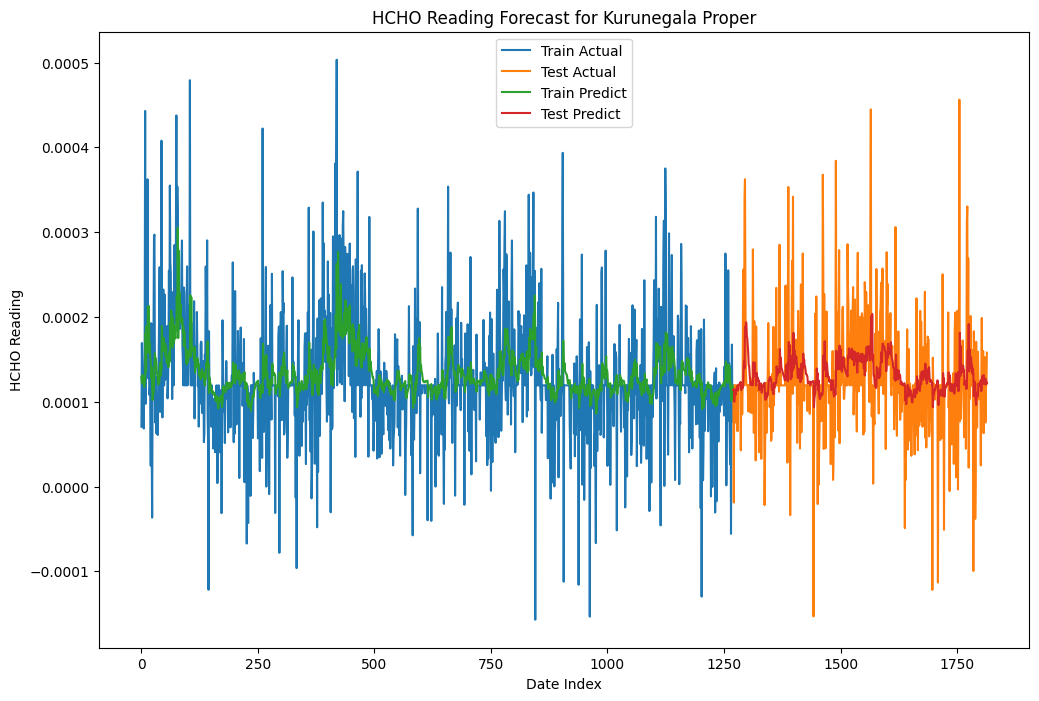

Processing Jaffna Proper...
Epoch 1/50
40/40 [==============================] - 8s 20ms/step - loss: 0.0206
Epoch 2/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0057
Epoch 3/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0057
Epoch 4/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0057
Epoch 5/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0057
Epoch 6/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0058
Epoch 7/50
40/40 [==============================] - 1s 20ms/step - loss: 0.0060
Epoch 8/50
40/40 [==============================] - 1s 30ms/step - loss: 0.0057
Epoch 9/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0056
Epoch 10/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0056
Epoch 11/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0056
Epoch 12/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0057
Epoch 13/

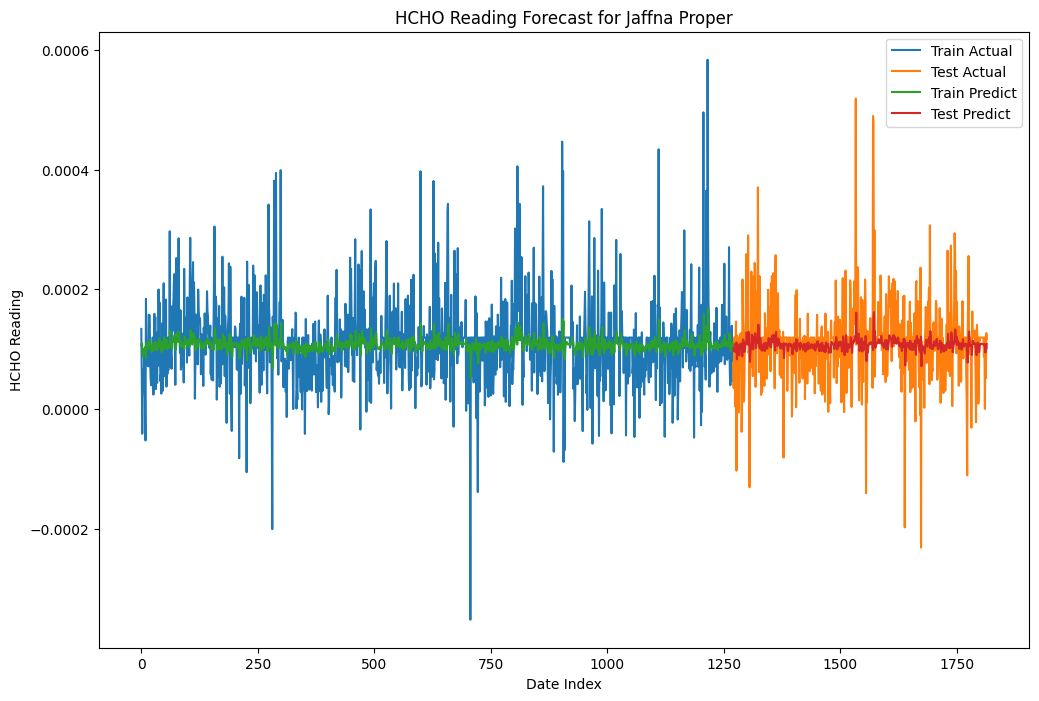

Processing Kandy Proper...
Epoch 1/50
40/40 [==============================] - 5s 20ms/step - loss: 0.0113
Epoch 2/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0053
Epoch 3/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0055
Epoch 4/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0053
Epoch 5/50
40/40 [==============================] - 1s 27ms/step - loss: 0.0054
Epoch 6/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0051
Epoch 7/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0054
Epoch 8/50
40/40 [==============================] - 1s 24ms/step - loss: 0.0054
Epoch 9/50
40/40 [==============================] - 1s 26ms/step - loss: 0.0052
Epoch 10/50
40/40 [==============================] - 1s 23ms/step - loss: 0.0053
Epoch 11/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0054
Epoch 12/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0052
Epoch 13/5

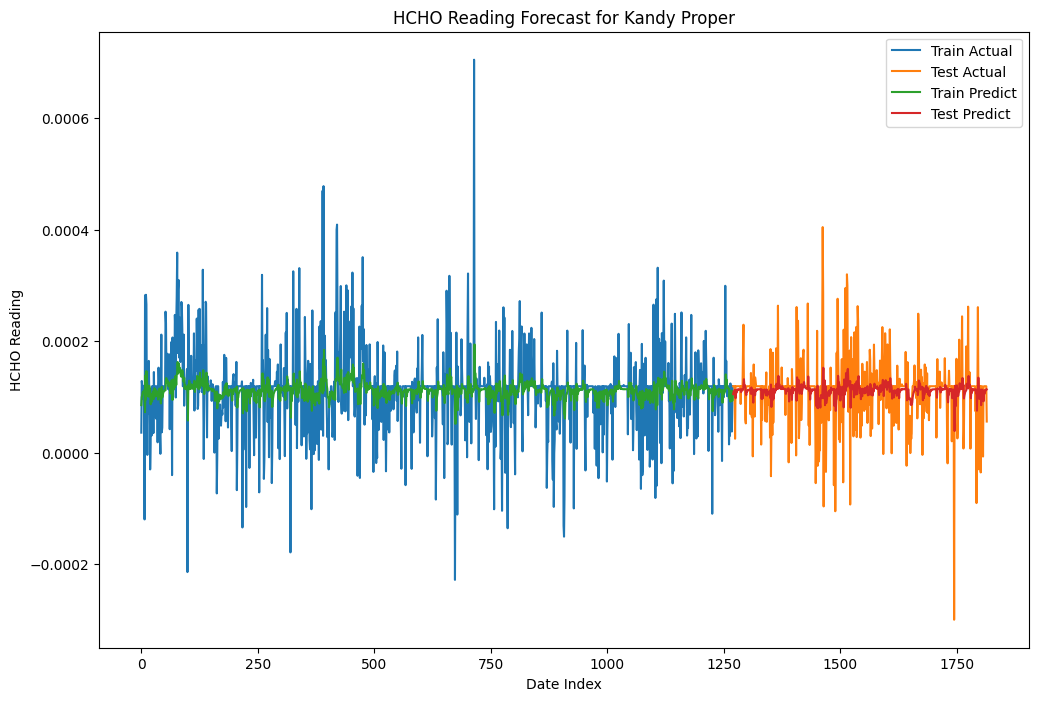

In [ ]:
for location in df_pandas['Location'].unique():

    print(f"Processing {location}...")

    loc_data = df_pandas[df_pandas['Location'] == location]
    loc_data['Current Date'] = pd.to_datetime(loc_data['Current Date'])
    loc_data.set_index('Current Date', inplace=True)



    if loc_data['HCHO Reading'].isnull().all():
        print(f"All data for {location} are NaN. Skipping...")
        continue



    # Normalize HCHO Reading
    loc_data['Scaled HCHO'] = scaler.fit_transform(loc_data[['HCHO Reading']])
    X, y = create_dataset(loc_data['Scaled HCHO'].values, time_step=10)
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input


    if len(X) < 10:
        print(f"Not enough data to fit LSTM for {location}")
        continue


    train_size = int(len(X) * 0.70)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]




    model = Sequential([
      LSTM(50, return_sequences=True, input_shape=(10, 1)),
      LSTM(50),
      Dense(1)

    ])



    model.compile(optimizer=Adam(0.01), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=5, verbose=1, mode='auto')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Store results
    results[location] = (train_predict, test_predict)

    # Compute and store evaluation metrics
    mse = mean_squared_error(y_test_inv, test_predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv, test_predict)
    mape = np.mean(np.abs((y_test_inv - test_predict) / y_test_inv)) * 100 if np.all(y_test_inv != 0) else None

    evaluation_metrics[location] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

    # Visualization for each location
    plt.figure(figsize=(12, 8))
    plt.plot(y_train_inv, label='Train Actual')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, label='Test Actual')
    plt.plot(train_predict, label='Train Predict')
    plt.plot(np.arange(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict')
    plt.title(f'HCHO Reading Forecast for {location}')
    plt.xlabel('Date Index')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.show()

In [ ]:
# Optionally convert results and metrics to DataFrame for further analysis
forecast_df = pd.DataFrame.from_dict({k: [v[0], v[1]] for k, v in results.items()}, orient='index')
metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index')
print(metrics_df)

                              MSE      RMSE       MAE         MAPE
Colombo Proper       5.831354e-09  0.000076  0.000056   113.991358
Deniyaya, Matara     4.294061e-09  0.000066  0.000046  1415.420277
Nuwara Eliya Proper  2.567264e-09  0.000051  0.000032   165.068642
Bibile, Monaragala   5.351406e-09  0.000073  0.000050   119.752507
Kurunegala Proper    4.390744e-09  0.000066  0.000044    86.583348
Jaffna Proper        4.850923e-09  0.000070  0.000047   375.057340
Kandy Proper         3.494955e-09  0.000059  0.000036   147.804384


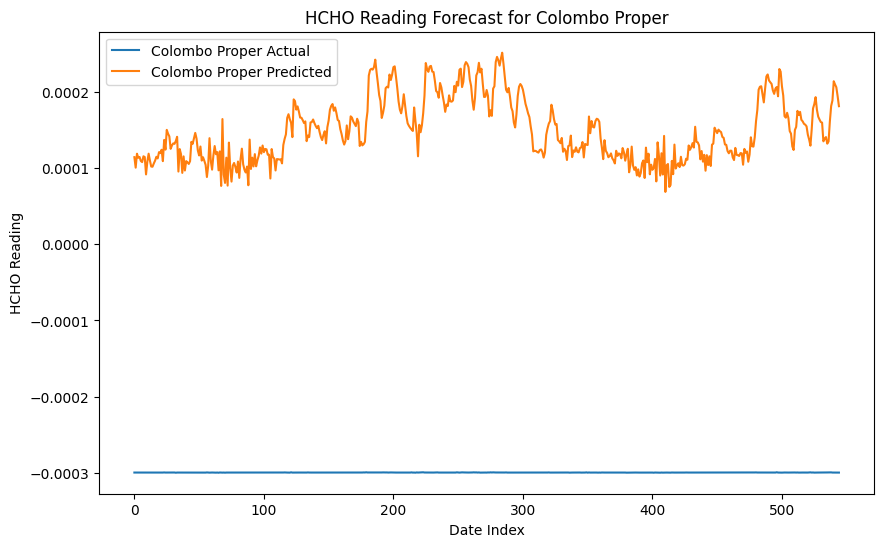

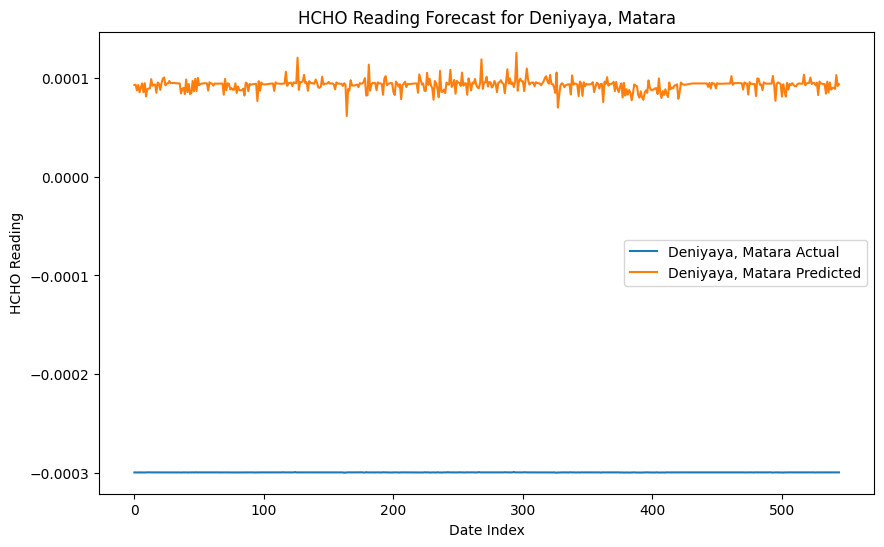

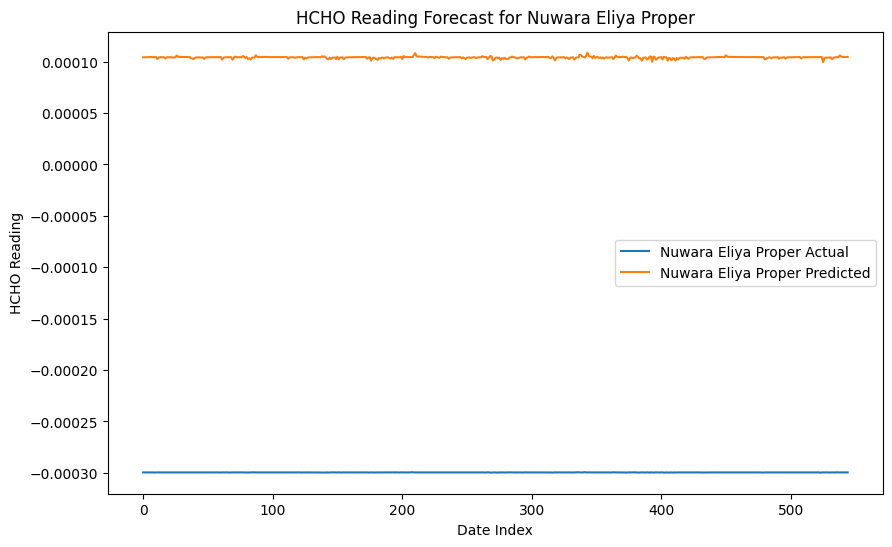

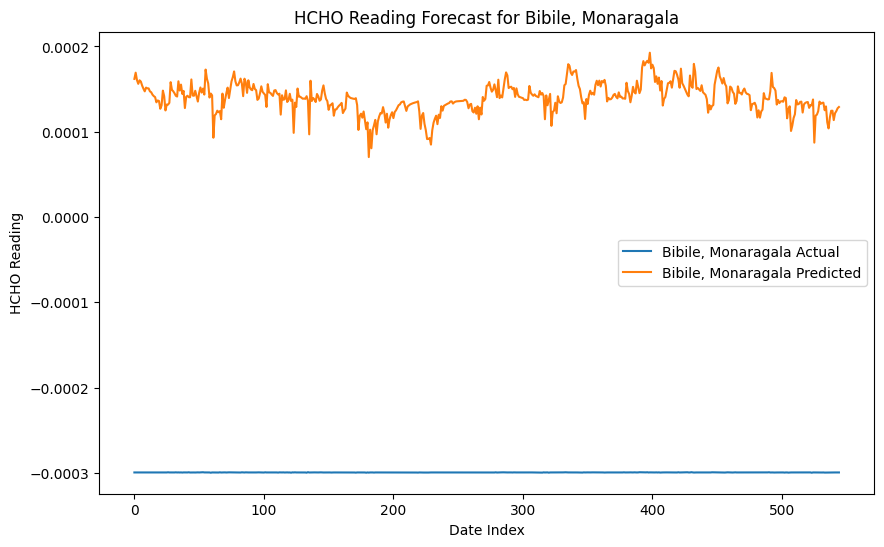

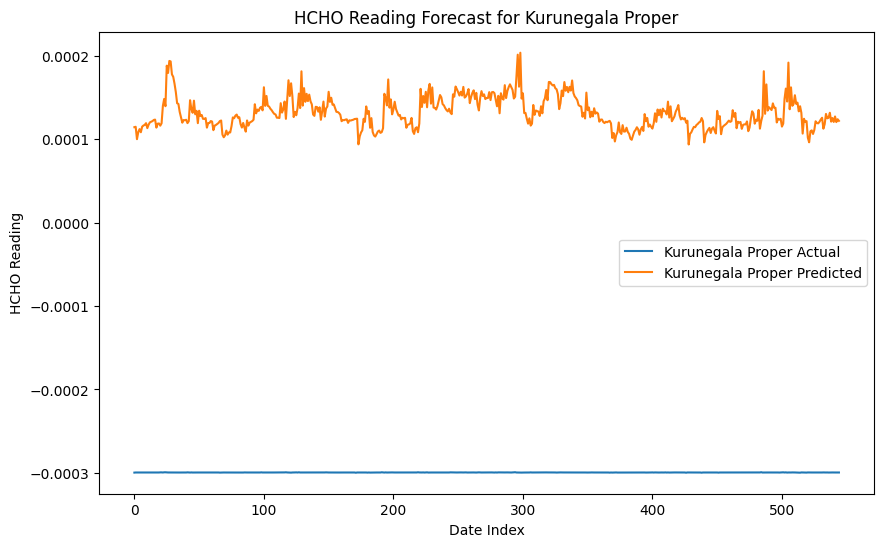

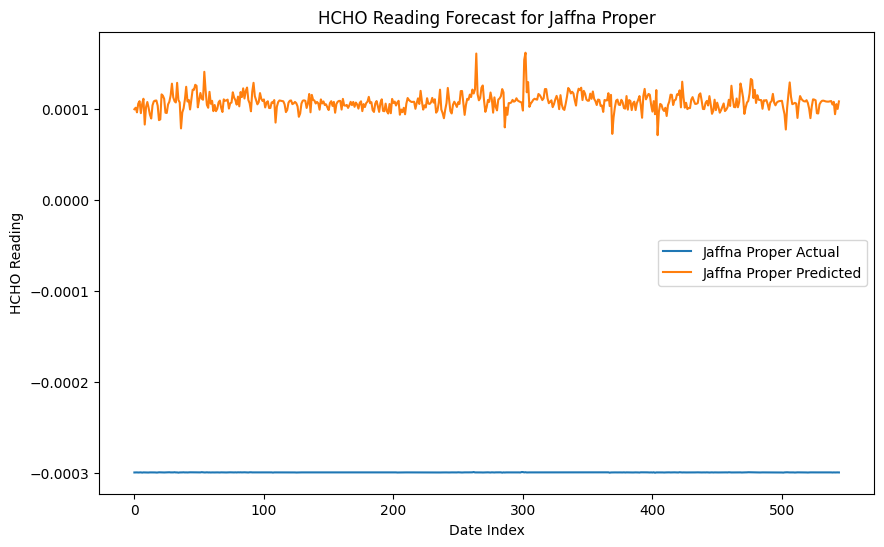

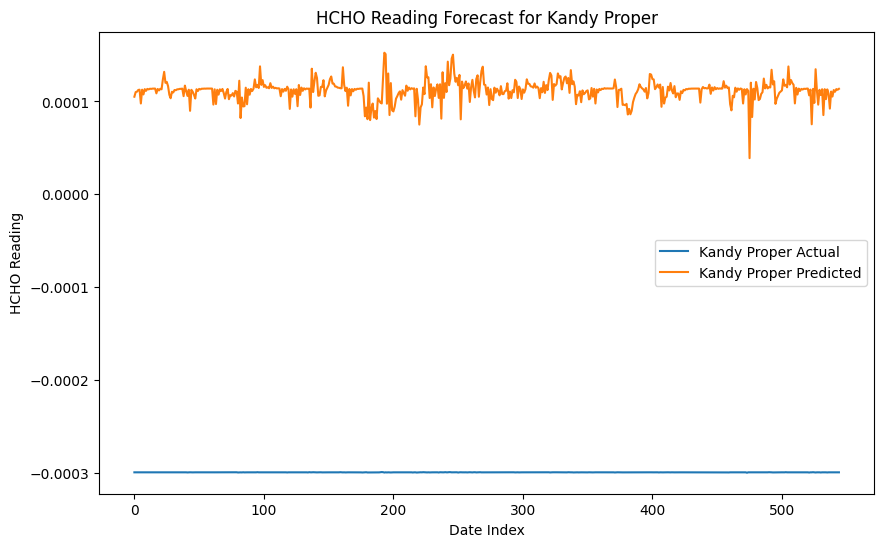

In [ ]:
# Plot forecasted values along with actual values for each location
for location, (train_predict, test_predict) in results.items():

    loc_data = df_pandas[df_pandas['Location'] == location]
    loc_data['Current Date'] = pd.to_datetime(loc_data['Current Date'])
    loc_data.set_index('Current Date', inplace=True)
    y_test_inv = scaler.inverse_transform(loc_data['HCHO Reading'].iloc[-len(test_predict):].values.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label=f'{location} Actual', linestyle='-')
    plt.plot(test_predict, label=f'{location} Predicted')
    plt.title(f'HCHO Reading Forecast for {location}')
    plt.xlabel('Date Index')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.show()


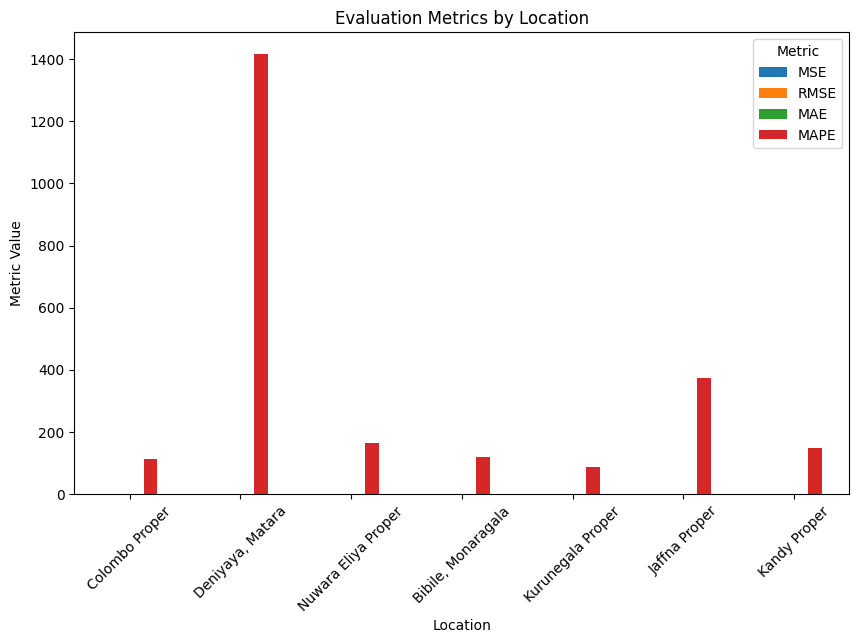

In [ ]:
# Plot evaluation metrics
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Evaluation Metrics by Location')
plt.xlabel('Location')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()

#**4. Additional Explantory Data Analysis**

In [ ]:
from pyspark.sql.functions import col

# Assuming df_spark is your original DataFrame
df_spark_additional = df_spark.select([col(col_name).alias(col_name) for col_name in df_spark.columns])

In [ ]:
from pyspark.sql.functions import col

# Define the locations to keep
locations_to_keep = ['Kurunegala Proper', 'Colombo Proper', 'Nuwara Eliya Proper']

# Filter the DataFrame to keep only the rows with the specified locations
filtered_df = df_spark_additional.filter(col('Location').isin(locations_to_keep))

# Get unique locations from the filtered DataFrame
unique_locations = filtered_df.select('Location').distinct().rdd.map(lambda row: row[0]).collect()

# Print the unique locations
for location in unique_locations:
    print(location)

Colombo Proper
Nuwara Eliya Proper
Kurunegala Proper


In [ ]:
# Reading the file
additional_data = spark.read.csv("/content/drive/My Drive/Data Engineering/additional_data.csv", header=False, inferSchema = True)

print(additional_data.columns)

# Define the columns you want to drop
columns_to_drop = ['_c0', '_c2', '_c3', '_c4', '_c7', '_c9','_c10', '_c11', '_c12','_c13']

# Drop the specified columns
additional_data = additional_data.drop(*columns_to_drop)

print(additional_data.columns)



# # Rename the columns to more meaningful names
additional_spark = additional_data.withColumnRenamed('_c1', 'Location') \
                   .withColumnRenamed('_c5', 'Current Date') \
                   .withColumnRenamed('_c6', 'Precipitation') \
                   .withColumnRenamed('_c8', 'Temperature Average')


# Convert Spark DataFrame to Pandas DataFrame
additional_pandas = additional_spark.toPandas()

# Print the Pandas DataFrame
print(additional_pandas)

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13']
['_c1', '_c5', '_c6', '_c8']
            Location Current Date Precipitation Temperature Average
0               NAME         DATE          PRCP                TAVG
1     KURUNEGALA, CE   2019-01-02          0.00                  78
2     KURUNEGALA, CE   2019-01-03          0.00                  81
3     KURUNEGALA, CE   2019-01-04          0.00                  83
4     KURUNEGALA, CE   2019-01-05          0.00                  84
...              ...          ...           ...                 ...
8741    PUTTALAM, CE   2023-12-27          0.00                  81
8742    PUTTALAM, CE   2023-12-28          0.01                  80
8743    PUTTALAM, CE   2023-12-29          0.52                  80
8744    PUTTALAM, CE   2023-12-30          0.48                  78
8745    PUTTALAM, CE   2023-12-31          0.57                  81

[8746 rows x 4 columns]


In [ ]:
# Assuming 'Location' is the column containing location information
unique_locations = additional_pandas['Location'].unique()

# List of locations to remove
locations_to_remove = ['CHINA BAY, CE', 'PUTTALAM, CE']

# Filter out unwanted rows
filtered_data = additional_pandas[~additional_pandas['Location'].isin(locations_to_remove)]
additional_pandas = filtered_data.copy()

# Print the modified DataFrame
for location in filtered_data['Location'].unique():
    print(location)



NAME
KURUNEGALA, CE
COLOMBO, CE
NUWARA ELIYA, CE


In [ ]:
# Assuming 'Location' is the column containing location information
additional_pandas['Location'] = additional_pandas['Location'].replace({
    'KURUNEGALA, CE': 'Kurunegala Proper',
    'COLOMBO, CE': 'Colombo Proper',
    'NUWARA ELIYA, CE': 'Nuwara Eliya Proper'
})

# Filter out unwanted entries including 'NAME'
filtered_locations = additional_pandas['Location'].unique()
filtered_locations = [location for location in filtered_locations if location != 'NAME']

for location in filtered_locations:
    print(location)



Kurunegala Proper
Colombo Proper
Nuwara Eliya Proper


In [ ]:
# Delete the first row of the DataFrame
additional_pandas = additional_pandas.drop(0)

# Print the modified DataFrame
print(additional_pandas)


                 Location Current Date Precipitation Temperature Average
1       Kurunegala Proper   2019-01-02          0.00                  78
2       Kurunegala Proper   2019-01-03          0.00                  81
3       Kurunegala Proper   2019-01-04          0.00                  83
4       Kurunegala Proper   2019-01-05          0.00                  84
5       Kurunegala Proper   2019-01-06          0.00                  82
...                   ...          ...           ...                 ...
6986  Nuwara Eliya Proper   2023-12-27          0.35                  61
6987  Nuwara Eliya Proper   2023-12-28          2.44                  61
6988  Nuwara Eliya Proper   2023-12-29          0.64                  60
6989  Nuwara Eliya Proper   2023-12-30          0.21                  60
6990  Nuwara Eliya Proper   2023-12-31          0.28                  60

[5230 rows x 4 columns]


In [ ]:
from pyspark.sql.functions import col

# Convert 'Current Date' to datetime object specifying the date format
# additional_pandas['Current Date'] = pd.to_datetime(additional_pandas['Current Date'], format='%Y/%m/%d')
additional_pandas['Current Date'] = pd.to_datetime(additional_pandas['Current Date'], format='%Y-%m-%d', errors='coerce')

# Check for any NaT entries which indicate failed conversions
print(additional_pandas[additional_pandas['Current Date'].isna()])

# Convert the Pandas DataFrame to a Spark DataFrame
additional_spark = spark.createDataFrame(additional_pandas)

# Join the two DataFrames based on 'Location' and 'Current Date'
joined_data = df_spark_additional.join(additional_spark, on=['Location', 'Current Date'], how='inner')

# Print the joined DataFrame
joined_data.show()

Empty DataFrame
Columns: [Location, Current Date, Precipitation, Temperature Average]
Index: []
+-----------------+------------+--------------------+----------+-------------+-------------------+
|         Location|Current Date|        HCHO Reading| Next Date|Precipitation|Temperature Average|
+-----------------+------------+--------------------+----------+-------------+-------------------+
|Kurunegala Proper|  2019-01-02|1.370787402778218...|2019-01-03|         0.00|                 78|
|Kurunegala Proper|  2019-01-03|1.480085027113037E-4|2019-01-04|         0.00|                 81|
|Kurunegala Proper|  2019-01-04|-2.04637905973554...|2019-01-05|         0.00|                 83|
|Kurunegala Proper|  2019-01-05|2.489134742856164E-4|2019-01-06|         0.00|                 84|
|Kurunegala Proper|  2019-01-06|1.015583300177078...|2019-01-07|         0.00|                 82|
|Kurunegala Proper|  2019-01-07|1.919056668190272...|2019-01-08|         0.00|                 80|
|Kurunegala P

In [ ]:
joined_data.head()

Row(Location='Kurunegala Proper', Current Date=datetime.date(2019, 1, 2), HCHO Reading=0.00013707874027782185, Next Date=datetime.date(2019, 1, 3), Precipitation='0.00', Temperature Average='78')

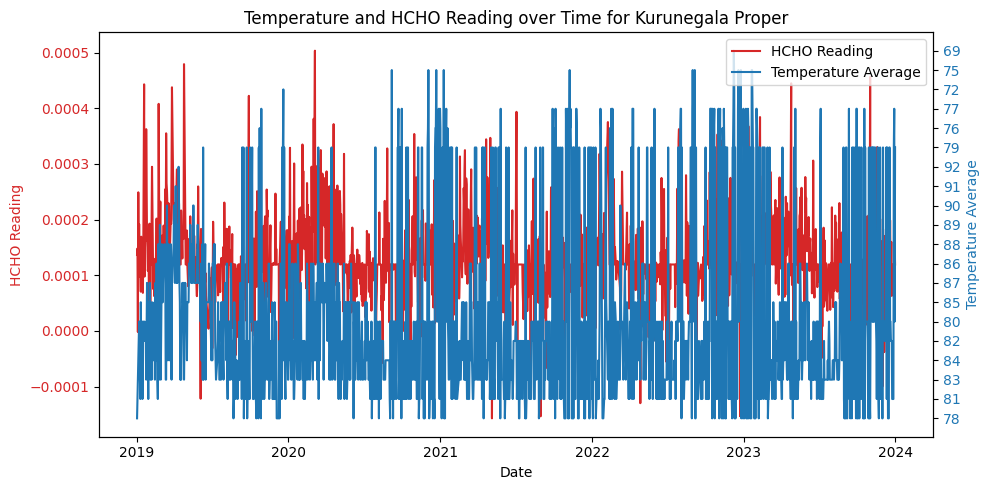

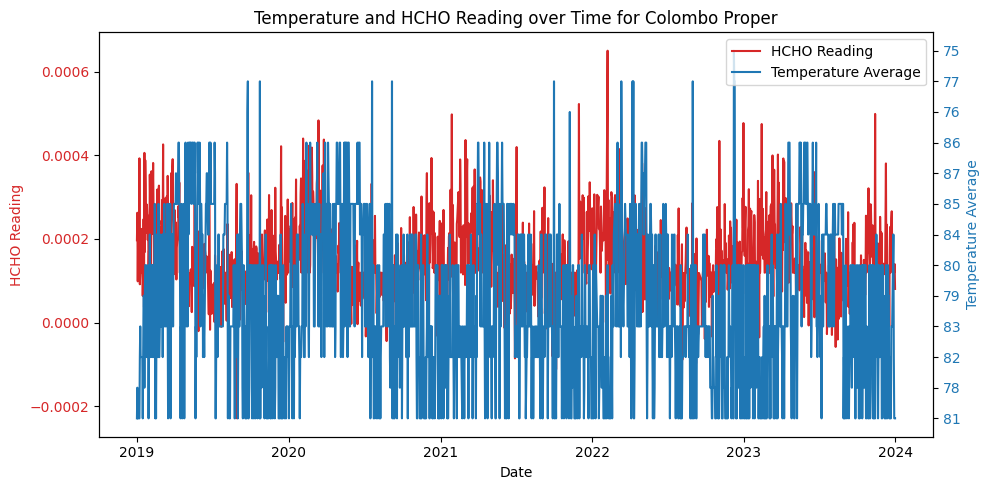

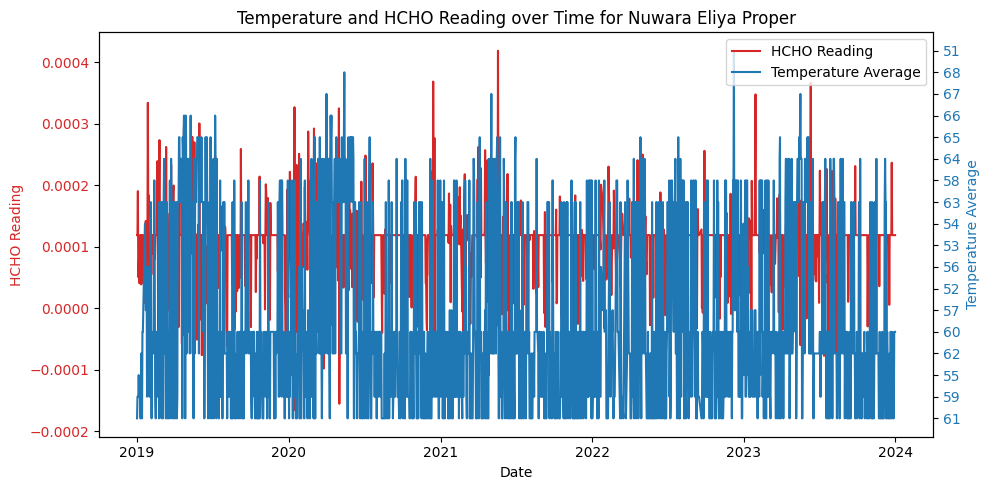

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'joined_data' is a Spark DataFrame
pandas_df = joined_data.toPandas()

# Convert 'Current Date' to datetime if it's not already
pandas_df['Current Date'] = pd.to_datetime(pandas_df['Current Date'])

# Getting unique locations
locations = pandas_df['Location'].unique()

# Plotting data for each location
for location in locations:
    # Filter data for the current location
    loc_data = pandas_df[pandas_df['Location'] == location]

    # Sorting data by date to ensure the plot lines are continuous and correct
    loc_data = loc_data.sort_values('Current Date')

    # Creating the plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plotting 'HCHO Reading' on the primary y-axis
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('HCHO Reading', color=color)
    ax1.plot(loc_data['Current Date'], loc_data['HCHO Reading'], color=color, label='HCHO Reading')
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating a second y-axis for 'Temperature'
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Temperature Average', color=color)
    ax2.plot(loc_data['Current Date'], loc_data['Temperature Average'], color=color, label='Temperature Average')
    ax2.tick_params(axis='y', labelcolor=color)

    # Adding a title
    plt.title(f'Temperature and HCHO Reading over Time for {location}')

    # Displaying the legend
    # This ensures that the legend contains labels from both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Layout adjustment
    plt.tight_layout()

    # Show plot
    plt.show()


Location                       object
Current Date           datetime64[ns]
HCHO Reading                  float64
Next Date                      object
Precipitation                 float64
Temperature Average            object
dtype: object


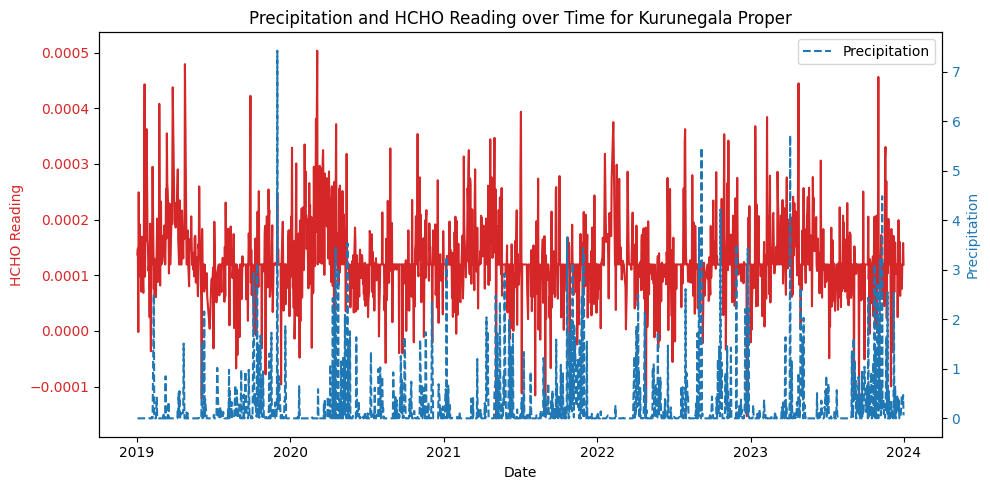

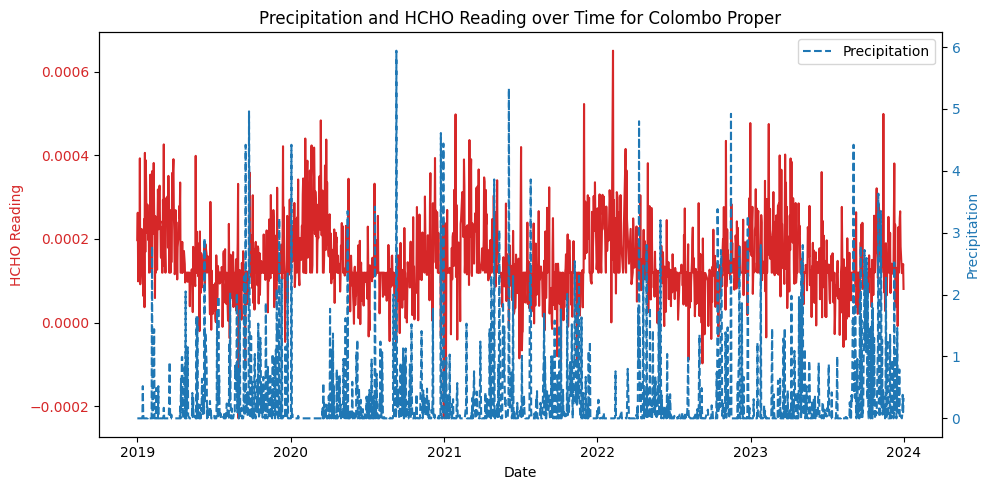

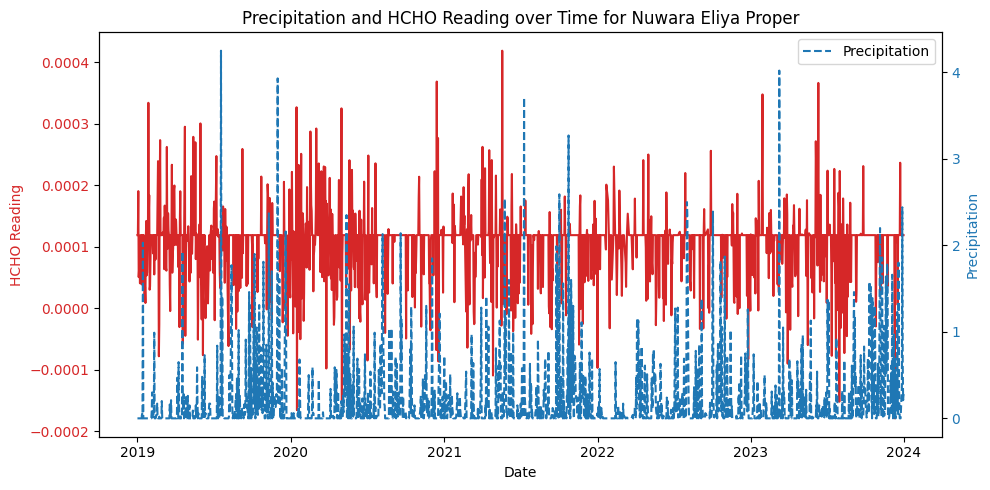

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'joined_data' is a Spark DataFrame and converting it to Pandas
pandas_df = joined_data.toPandas()

# Converting 'Current Date' to datetime and handling NaNs for 'Precipitation'
pandas_df['Current Date'] = pd.to_datetime(pandas_df['Current Date'])
pandas_df['Precipitation'] = pandas_df['Precipitation'].fillna(0.0).astype(float)

# Printing data types to debug
print(pandas_df.dtypes)

# Plotting for each location
locations = pandas_df['Location'].unique()
for location in locations:
    loc_data = pandas_df[pandas_df['Location'] == location]
    loc_data = loc_data.sort_values('Current Date')

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('HCHO Reading', color='tab:red')
    ax1.plot(loc_data['Current Date'], loc_data['HCHO Reading'], color='tab:red', label='HCHO Reading')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Precipitation', color='tab:blue')
    ax2.plot(loc_data['Current Date'], loc_data['Precipitation'], color='tab:blue', label='Precipitation', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax2.legend(loc='upper right')
    plt.title(f'Precipitation and HCHO Reading over Time for {location}')
    plt.tight_layout()
    plt.show()